<span style="font-size: 14px;"><b>Problem Statement:</b><br>
While LoanTap has a generally healthy loan portfolio with 80% of loans being fully paid, there remains room for improvement in reducing the 20% default rate to enhance profitability and reduce financial risk.Additionally, LoanTap faces challenges in optimizing loan approval processes and tailoring loan products to different customer segments and geographical areas to minimize defaults and maximize returns.
</span>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')
import time
import re
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc, precision_score, recall_score, precision_recall_curve
from mlxtend.plotting import plot_confusion_matrix
from copy import deepcopy
from beautifultable import BeautifulTable

pd.set_option('display.max_columns', 500)

In [7]:
data=pd.read_csv('logistic_regression.csv')
data.drop_duplicates(keep='first',inplace=True)

dm=data.copy()
##too much cardinality with title and emp_title variables -- dropping them
data.drop(['title','emp_title'],axis=1,inplace=True)

data.reset_index(drop=True,inplace=True)

In [8]:
##Variables with missing values
null_cols=data.isna().sum(axis=0).reset_index()
null_cols.columns=['columns','null_counts']
null_cols=null_cols.loc[null_cols.null_counts>0].sort_values('null_counts',ascending=False)

null_cols['null_percent']=100*null_cols['null_counts']/len(data)
null_cols.reset_index(drop=True,inplace=True)
null_cols

,columns,null_counts,null_percent
0,mort_acc,37795,9.543469
1,emp_length,18301,4.621115
2,pub_rec_bankruptcies,535,0.135091
3,revol_util,276,0.069692


In [9]:

## narrow transform -- dates (extracting quarter from here)
def convert_dates(df,col):
    data=df.copy()
    dates=data[col].str.split('-',expand=True)
    dates.columns=['mon','year']

    map_months=pd.date_range('2000-01-01','2000-12-31',freq='MS').strftime("%b").tolist()
    map_months={i[1]:i[0]+1 for i in enumerate(map_months)}
    
    dates['mon']=pd.to_numeric(dates.mon.map(map_months),errors='coerce')
    dates['year']=pd.to_numeric(dates['year'],errors='coerce')
    dates.columns=[col+'_mon',col+'_year']
    dates[col+'_Q']=(1+((dates[col+'_mon']-1)//3)).astype(str)
    
    data.drop([col],axis=1,inplace=True)
    data=pd.concat([data,dates[[col+'_Q']]],axis=1)
    return data

## One hot encoding
def dummy_str_col(d,cols):
    data=d.copy()
    drop_str_cols=[]
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        drop_str_cols.append(str_data.columns[-1])
        str_data.drop(str_data.columns[-1],axis=1,inplace=True)
    
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)
    return data,drop_str_cols

def test_str_col(d,cols,drop_str_cols):
    data=d.copy()
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)

    for drop_col in drop_str_cols:
        data.drop(drop_col,axis=1,inplace=True)
        
    return data



### Outlier Treatment
def treat_outliers_zscore(data,col):
    s=data[col].describe()
    le=s['mean']-3*(s['std'])
    
    ue=s['mean']+3*(s['std'])
    d=data.copy()
    d.loc[d[col]<le,col]=le
    d.loc[d[col]>ue,col]=ue
    
    return d[col],le,ue

def treat_test_outliers_zscore(data,col,le,ue):
    d=data.copy()
    d.loc[d[col]<le,col]=le
    d.loc[d[col]>ue,col]=ue
    
    return d[col]

<span style="font-size: 20px;">========Narrow Transformations==============</span>

<span style="font-size: 14px;">Defining broader categories for purpose variable to reduce cardinality<br>
1- Debt: ['debt_consolidation', 'credit_card']<br>
2- Home: ['home_improvement', 'house', 'moving']<br>
3- Business: ['small_business']<br>
4- Personal: ['vacation', 'major_purchase', 'medical', 'wedding', 'car', 'other']<br>
5- Education: ['educational']<br>
6- Energy: ['renewable_energy']</span>

In [10]:
dm.application_type.value_counts()

#severely imbalanced
# There are 99% single borrower applications submitted to LoanTap 

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [11]:
def make_emplength_ordinal(x):
    if isinstance(x,str):
        return 0 if ''.join(re.findall('([^ A-Za-z\+]+)',x))=='<1' else int(''.join(re.findall('([^ A-Za-z\+]+)',x)))
    return x

def narrow_transformations(data,just_exploring=True,is_test=False,drop_str_cols=[]):
    df=data.copy()
    
    ##ordinals to numerical
    mapp_target={'Fully Paid':0,'Charged Off':1}  ##Recall is important here 
    df.loc[:,'loan_status']=df.loan_status.map(mapp_target)
    
    
    df.loc[:,'term']=df.term.apply(lambda x:int(re.findall('[^ A-Za-z]+',x)[0]))
    
    #mapp={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
    #df.loc[:,'grade']=df.grade.map(mapp)
    df.loc[:,'sub_grade']=df.sub_grade.apply(lambda x:int(re.findall('(\d)',x)[0])) #extracts 1 from A1 (A already taken care by Grade)
    
    df.loc[df.home_ownership.isin(['OTHER','NONE','ANY']),'home_ownership']='OTHER' ##broader category
    
    purpose_mapping = {
    'vacation': 'Personal',
    'debt_consolidation': 'Debt',
    'credit_card': 'Debt',
    'home_improvement': 'Home',
    'small_business': 'Business',
    'major_purchase': 'Personal',
    'other': 'Personal',
    'medical': 'Personal',
    'wedding': 'Personal',
    'car': 'Personal',
    'moving': 'Home',
    'house': 'Home',
    'educational': 'Education',
    'renewable_energy': 'Energy'
    }
    df['broad_purpose'] = df['purpose'].map(purpose_mapping)
    
    #df.loc[df.application_type.isin(['JOINT','DIRECT_PAY']),'application_type']='MINORITY'
    
    df['state']=df.address.apply(lambda x:''.join(re.findall(' ([A-Z]{2}) ',x)))
    df['pincode']=df.address.apply(lambda x:str(x.split(' ')[-1]))
    
    df.loc[:,'emp_length']=df.emp_length.apply(make_emplength_ordinal)
    df=convert_dates(df,'earliest_cr_line')
    df=convert_dates(df,'issue_d')
    
    if not just_exploring:
        if is_test:
            df=test_str_col(df,['grade','sub_grade','home_ownership','application_type'
                                ,'broad_purpose','earliest_cr_line_Q','issue_d_Q'
                                ,'verification_status','initial_list_status','pincode'],drop_str_cols)
        else:
            df,drop_str_cols=dummy_str_col(df,['grade','sub_grade','home_ownership','application_type'
                                ,'broad_purpose','earliest_cr_line_Q','issue_d_Q'
                                ,'verification_status','initial_list_status','pincode'])
        
    
    df.drop(['address','purpose'],axis=1,inplace=True) 
    
    
    return df,drop_str_cols

In [12]:
df,drop_str_cols=narrow_transformations(data,just_exploring=True,is_test=False,drop_str_cols=[])


In [13]:
##Defaulter Distribution across different purposes

print(df.broad_purpose.value_counts(normalize=True))

purp=df.groupby(['broad_purpose']).agg(loan_stat_sum=('loan_status','sum'),loan_stat_count=('loan_status','count'))
purp['defaulters%']=100*purp['loan_stat_sum']/purp['loan_stat_count']
print(purp)

Debt         0.801773
Personal     0.108911
Home         0.073441
Business     0.014395
Energy       0.000831
Education    0.000649
Name: broad_purpose, dtype: float64
               loan_stat_sum  loan_stat_count  defaulters%
broad_purpose                                             
Business                1679             5701    29.450974
Debt                   62514           317526    19.687837
Education                 42              257    16.342412
Energy                    77              329    23.404255
Home                    5191            29085    17.847688
Personal                8170            43132    18.941853


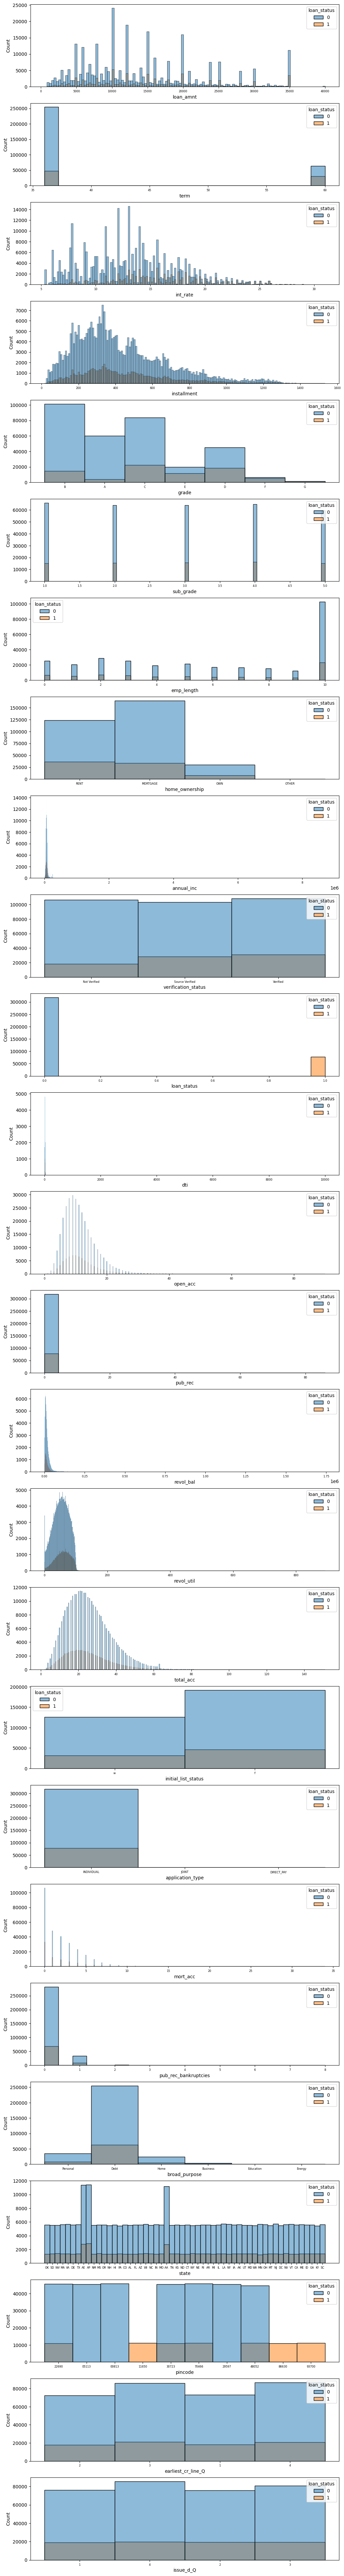

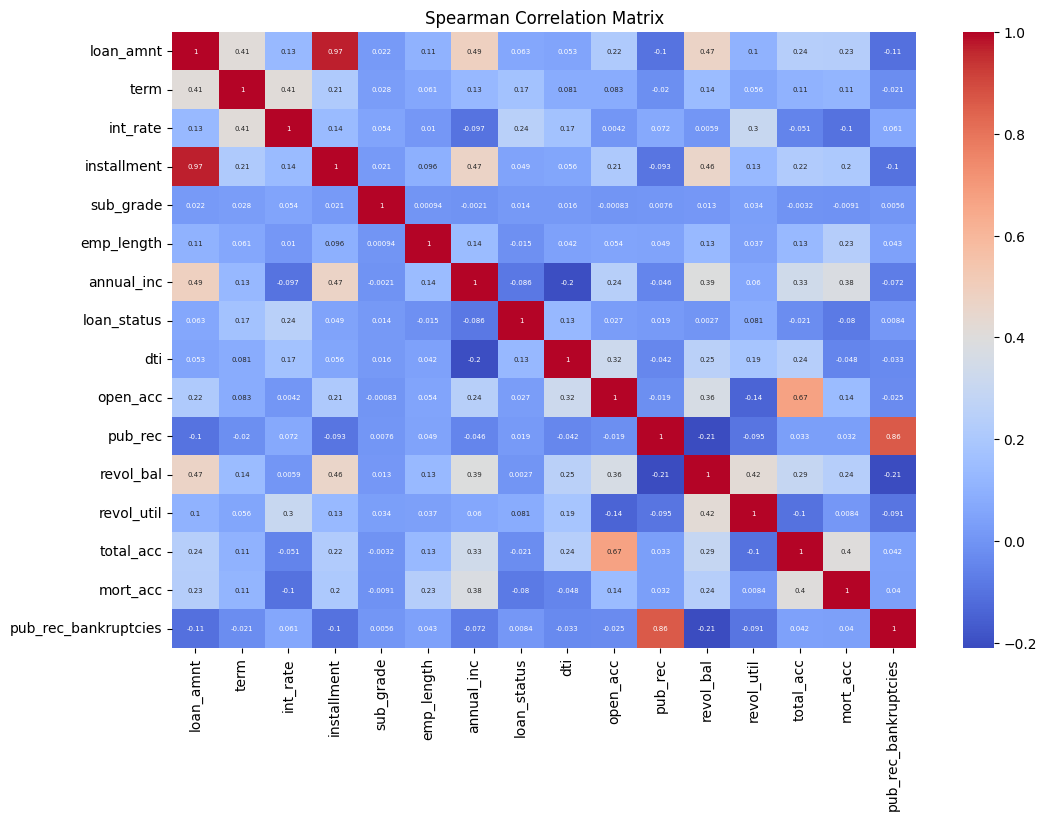

,Field1,Field2,Correlation
0,installment,loan_amnt,0.968334
1,pub_rec,pub_rec_bankruptcies,0.862245
2,open_acc,total_acc,0.672232
3,annual_inc,loan_amnt,0.488566
4,annual_inc,installment,0.470464
...,...,...,...
115,sub_grade,total_acc,-0.003182
116,loan_status,revol_bal,0.002671
117,annual_inc,sub_grade,-0.002050
118,emp_length,sub_grade,0.000945


In [14]:
def plotting_numeric_cols(data,num_cols):
    fig,axes=plt.subplots(nrows=len(num_cols),ncols=1,figsize=(12,100)) 
    for i,column in enumerate(num_cols):
        try:
            #sns.distplot(data[column],kde=True,ax=axes[i],norm_hist=False)
            sns.histplot(data=data, x=column, hue='loan_status', kde=False, ax=axes[i], common_norm=False)
            axes[i].tick_params(axis='x',labelsize=6)
            #axes[i].set_title(f'Histogram of {column}')

        except:
            #sns.histplot(data[column],ax=axes[i])
            sns.histplot(data=data, x=column, hue='loan_status', ax=axes[i])
            axes[i].tick_params(axis='x',labelsize=6)
            #axes[i].set_title(f'Histogram of {column}')
        
    
    plt.show()
    
    #print(data.info(),data.dtypes)
    d=data.loc[:,data.dtypes!='O']
    plt.figure(figsize=(12,8))
    sns.heatmap(d.corr(method='spearman'),annot=True,cmap='coolwarm',annot_kws={'size':5})
    plt.title('Spearman Correlation Matrix')
    plt.show()
    
    #     plt.figure(figsize=(12,8))
    #     sns.pairplot(d,hue='loan_status')
    #     plt.title('PairPlot')
    #     plt.show()
    
    return d.corr(method='spearman')

num_cols=df.columns    
corr=plotting_numeric_cols(df,num_cols)
value_vars=corr.columns
corr.reset_index(inplace=True)
corr1=pd.melt(corr,id_vars='index',value_vars=value_vars)
corr1=corr1.loc[corr1.value!=1]

for ind,row in corr1.iterrows():
    corr1.loc[ind,['index','variable']]=corr1.loc[ind,['index','variable']].sort_values(ascending=True).values

corr1.drop_duplicates(keep='first',inplace=True)

corr1['abs_val']=corr1['value'].abs()
corr1=corr1.sort_values('abs_val',ascending=False)
corr1.reset_index(drop=True,inplace=True)
corr1.drop('abs_val',axis=1,inplace=True)
corr1.columns=['Field1','Field2','Correlation']
corr1

<span style="font-size: 14px;">The loan amount (loan_amnt) is highly correlated with the installment (installment), with a Spearman correlation coefficient of 0.97.<br><br>
This high correlation is expected because the installment amount is directly calculated based on the loan amount, the loan term (term), and the interest rate (int_rate). Specifically, the installment represents the monthly payment the borrower needs to make, which is inherently dependent on the total loan amount. Therefore, a strong relationship between these two variables is anticipated and reflects the underlying financial calculation.</span>

In [15]:
#Relation with loan_status
#Loan Amount (loan_amnt): Higher loan amounts might be riskier, influencing loan status.
#Interest Rate (int_rate): Higher interest rates might correlate with higher risk.
#Employment Length (emp_length): Longer employment might indicate stability, influencing loan approval.
#Debt-to-Income Ratio (dti): Higher DTI might indicate higher risk of default.
#Credit History (open_acc, revol_bal, revol_util, total_acc): These features provide insights into the borrower's creditworthiness.

<span style="font-size: 14px;">=========Comment on Outliers============</span>

In [16]:
#outliers
des=df.describe().copy()

lower_threshold=(des.loc['mean']-3*des.loc['std']).to_frame().T
lower_threshold.index=['Lower_Threshold']
upper_threshold=(des.loc['mean']+3*des.loc['std']).to_frame().T
upper_threshold.index=['Upper_Threshold']

thresholds=pd.concat([des,lower_threshold,upper_threshold],axis=0)

counts=[[],[]]
for col in thresholds.columns:
    lt=thresholds.loc['Lower_Threshold',col]
    lts=len(df.loc[df[col]<lt])
    counts[0].append(lts)
    ut=thresholds.loc['Upper_Threshold',col]
    uts=len(df.loc[df[col]>ut])
    counts[1].append(uts)
    
counts=pd.DataFrame(counts,index=['Volume_below_Lower_Threhold','Volume_above_Upper_Threhold'],columns=thresholds.columns)
thresholds=pd.concat([thresholds,counts],axis=0)
thresholds=thresholds.loc[['count', 'mean', 'std','Volume_below_Lower_Threhold','Lower_Threshold', 'min'
, '25%', '50%', '75%', 'max', 'Upper_Threshold','Volume_above_Upper_Threhold']]
thresholds

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,377729.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,41.698053,13.639400,431.849698,2.971798,5.938578,7.420318e+04,0.196129,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,10.212038,4.472157,250.727790,1.406773,3.645623,6.163762e+04,0.397068,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
Volume_below_Lower_Threhold,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
Lower_Threshold,-10958.435934,11.061938,0.222928,-320.333670,-1.248523,-4.998290,-1.107097e+05,-0.995074,-36.677763,-4.101793,-1.413821,-4.593097e+04,-19.564831,-10.246228,-4.629801,-0.946875
min,500.000000,36.000000,5.320000,16.080000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,36.000000,10.490000,250.330000,2.000000,3.000000,4.500000e+04,0.000000,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,36.000000,13.330000,375.430000,3.000000,6.000000,6.400000e+04,0.000000,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,36.000000,16.490000,567.300000,4.000000,10.000000,9.000000e+04,0.000000,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,60.000000,30.990000,1533.810000,5.000000,10.000000,8.706582e+06,1.000000,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


<span style="font-size: 14px;">Based on the Z-score outlier analysis, we observe a significant number of outliers in the upper extremes across various features. This indicates that many of the univariate distributions are right-skewed, particularly in the variables pub_rec, installment, and revol_bal.</span>

<span style="font-size: 14px;"><b>Questionnaire<br>Q1- What percentage of customers have fully paid their Loan Amount?</b><br>Ans- 80% customers have fully paid their loan amount</span>

In [17]:
df.loan_status.value_counts(normalize=True)

##{'Fully Paid':0,'Charged Off':1}  ##Recall is important here

0    0.803871
1    0.196129
Name: loan_status, dtype: float64

<span style="font-size: 14px;"><b>Q2- Comment about the correlation between Loan Amount and Installment features.</b>
<br>Ans- There is high Spearman correlation (0.97) between these two features 
This indicates high multicollinearity between these two features and high VIF that's why Loan Amount feature was dropped during model training while handling multicollinearity</span>

<span style="font-size: 14px;"><b>Q3- The majority of people have home ownership as _______</b>
<br>Ans- Mortgage (50%)</span>

In [18]:
df.home_ownership.value_counts(normalize=True)

##Imbalanced dataset

MORTGAGE    0.500841
RENT        0.403480
OWN         0.095311
OTHER       0.000369
Name: home_ownership, dtype: float64

<span style="font-size: 14px;"><b>Q4- People with grades ‘A’ are more likely to fully pay their loan. (T/F)</b>
<br>Ans- True, 94% of assigned 'A' grade customers fully pay their loan</span>

In [19]:
df.groupby(['grade']).agg({'loan_status':'mean'})

,loan_status
grade,
A,0.062879
B,0.125730
C,0.211809
D,0.288678
E,0.373634
F,0.427880
G,0.478389


<span style="font-size: 14px;"><b>Q5- Name the top 2 afforded job titles.</b>
<br>Ans- Based on the analysis of loan status by job titles, the top 2 job titles with the highest proportion of fully paid loans, considering a minimum of 1000 loans for reliability, are:
<br>1- Director: With 1089 loans issued, 84.11% of these loans are fully paid.
<br>2- Project Manager: With 1505 loans issued, 83.65% of these loans are fully paid.
These job titles exhibit strong repayment behavior, indicating lower risk and higher creditworthiness among individuals holding these positions.
</span>

In [20]:
dm.loc[:,'loan_status']=dm.loc[:,'loan_status'].map({'Fully Paid':0,'Charged Off':1})
aff_titles=dm.groupby(['emp_title']).loan_status.agg(['count','sum'])
aff_titles['fully paid%']=100*(aff_titles['count']-aff_titles['sum'])/aff_titles['count']
aff_titles.loc[aff_titles['count']>=1000].sort_values(['fully paid%'],ascending=False)


,count,sum,fully paid%
emp_title,,,
Director,1089,173,84.113866
Project Manager,1505,246,83.654485
Teacher,4389,857,80.473912
Office Manager,1218,248,79.638752
Registered Nurse,1856,380,79.525862
RN,1846,379,79.469122
Manager,4250,929,78.141176
Supervisor,1830,405,77.868852
General Manager,1074,249,76.815642


<span style="font-size: 14px;"><b>Q6- Thinking from a bank's perspective, which metric should our primary focus be on..
ROC AUC
<br>1- Precision
<br>2- Recall
    <br>3- F1 Score</b>

<br>Ans- From a bank's perspective, focusing on the F2-score is crucial because it emphasizes Recall, 
ensuring we capture the higher-risk defaulters, who constitute 20% of the dataset. This approach also balances Precision, minimizing the risk of denying loans to non-risky individuals. Thus, the F2-score is the most suitable metric to prioritize.</span>                                                           

<span style="font-size: 14px;"><b>Q7- How does the gap in precision and recall affect the bank?</b>
<br>Ans- Low Precision (High False Positives): If the model has low precision, it means that a high proportion of the loans predicted to default do not actually default. This can lead to denying loans to many creditworthy individuals, resulting in lost business opportunities and potential revenue for the bank.

Low Recall (High False Negatives): If the model has low recall, it means that a high proportion of actual defaulters are not identified. This can result in approving loans for individuals who are likely to default, increasing the bank's risk of financial losses.

Thus, balancing precision and recall is crucial for the bank to minimize financial risks while maximizing the approval of creditworthy loan applicants.</span>

<span style="font-size: 14px;"><b>Q8- Which were the features that heavily affected the outcome?</b>
<br>Ans- 
<br>1- Specific pincodes (11650, 86630) and certain terms (e.g., higher term, higher debt-to-income ratio (dti), higher number of open accounts (open_acc), higher revolving utilization (revol_util)) are associated with a higher probability of loan default.
<br>2- Higher annual income (annual_inc) and total accounts (total_acc) reduce the likelihood of default.
<br>3-Specific grades (A, B) and sub-grades (1, 2, 3, 4) are linked to lower default probabilities.
<br>4-Loans with certain purposes (e.g., Energy, Education, Home) and verified statuses are less likely to default.
</span>


In [24]:
#df.groupby(['pincode']).state.unique()

pincode
00813    [MA, VA, NM, MS, PA, DE, RI, AZ, NC, IA, SD, D...
05113    [SD, WV, AE, AL, WI, NC, MS, KS, AP, ND, IL, A...
11650    [VA, TX, MD, AA, AP, VT, KY, NM, ME, UT, AE, A...
22690    [OK, TX, AP, FL, NH, CT, AA, SD, AE, IL, NY, M...
29597    [OR, NH, CO, IN, OK, IL, OH, TN, WI, AE, FL, A...
30723    [DE, AE, HI, NH, CO, VA, AZ, AA, SD, TN, NE, N...
48052    [AE, IN, MO, TX, AR, PA, NE, RI, WI, HI, AA, W...
70466    [MS, CO, WI, WY, ND, UT, MA, WA, MN, NJ, AZ, N...
86630    [MI, TN, VA, AE, GA, SD, NC, NM, CA, ME, MD, R...
93700    [MD, MI, IL, AK, TN, OH, KS, ID, IA, KY, OK, N...
Name: state, dtype: object

<span style="font-size: 14px;"><b>Q9- Will the results be affected by geographical location? (Yes/No)</b><br>
Ans- Yes, pincode (derived from address) has significant impact on the outcome.</span>

<span style="font-size: 14px;"><b>Tradeoff Questions<br>1. How can we make sure that our model can detect real defaulters and there are fewer false positives?</b>

<br>Ans- To ensure accurate detection of defaulters while minimizing false positives (not allowing loans to non-risky borrowers), LoanTap should utilize advanced machine learning techniques like SVM, Decision-Trees, Random Forest and optimize the decision threshold using ROC and AUC analysis. Implementing stratified cross-validation (given a lot of imbalanced categories) will further refine the model, balancing risk and opportunity effectively. Regularizations and hyperparameter Tuning works here as well.

<br><b>2. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.</b>
<br>Ans- To mitigate the risk of NPAs, LoanTap should consider adjusting loan amounts based on the borrower’s risk profile to mitigate this risk (as per hypothesis test done). Following Insights and Recommendations can help:
<br><br>1-Data shows that higher loan amounts are associated with a higher likelihood of default. LoanTap should consider adjusting loan amounts based on the borrower’s risk profile to mitigate this risk.
<br><br>2- Borrower pincode significantly influences loan default rates, indicating the need for geographical considerations in risk assessment and loan approval processes. Implement stricter credit policies and lower loan limits for high-risk pincodes (11650, 86630) identified in the model.Focus on safer regions (e.g., pincodes 48052, 70466, 30723) where the default risk is significantly lower.
<br><br>3- Offer lower loan amounts and shorter terms to borrowers in higher-risk categories to mitigate potential losses.
<br><br>4- Cap the debt-to-income ratio and revolving utilization rates to reduce the risk of over-leveraging.
<br><br>5- Customers with 'A' grade ratings are significantly more likely to repay their loans fully, suggesting that focusing on acquiring and retaining high-grade customers can improve overall portfolio performance.
<br><br>6- Homeownership status (e.g., mortgage holders) correlates with lower default rates, indicating this as an important factor in credit assessments.
<br><br>7- Specific professions, such as Directors, Project Managers, Teachers and Managers , show higher rates of full repayment, indicating lower risk. LoanTap could benefit from targeting and tailoring loan products to these professional segments.
<br><br>8- Proactive Risk Mitigation:
<br>1. Develop early warning systems to monitor at-risk borrowers, particularly those with increasing dti and revol_util metrics.
<br>2. Provide financial counseling and restructuring options for borrowers showing signs of financial distress.

</span>

In [20]:
#Hypothesis test

from scipy import stats
def ind_ttest(data,col):
    #ind t-test (assuming Normal dist)
    #HO: The mean loan amount for charged-off loans is equal to the mean loan amount for fully paid loans.
    #H1: The mean loan amount for charged-off loans is different from the mean loan amount for fully paid loans.
    #significance level considered = 0.05
    
    fully_paid = data[data['loan_status'] == 0][col]
    charged_off = data[data['loan_status'] == 1][col]
    t_stat, p_value = stats.ttest_ind(fully_paid, charged_off)

    print('t_stat: {} with p_value: {}'.format(t_stat,p_value))
    if p_value<0.05:
        print('There is a statistically significant difference between the mean {} of charged-off and fully paid loans.'.format(col))
    else:
        print('There is no sufficient evidence of a significant difference between the means.')

In [21]:
print(df.groupby(['loan_status']).loan_amnt.describe())

ind_ttest(df,'loan_amnt')

                count          mean          std     min     25%      50%  \
loan_status                                                                 
0            318357.0  13866.878771  8302.319699   500.0  7500.0  12000.0   
1             77673.0  15126.300967  8505.090557  1000.0  8525.0  14000.0   

                 75%      max  
loan_status                    
0            19225.0  40000.0  
1            20000.0  40000.0  
t_stat: -37.72285152165538 with p_value: 0.0
There is a statistically significant difference between the mean loan_amnt of charged-off and fully paid loans.


<span style="font-size: 14px;">Based on the results of the hypothesis test, we have determined that there is a statistically significant difference between the mean loan amounts of charged-off and fully paid loans. Specifically, the mean loan amount for charged-off (defaulted) loans is 9% higher than that for fully paid loans. This suggests that LoanTap may be more lenient in extending higher loan amounts to borrowers who are at a greater risk of default.</span>

In [31]:
print(df.groupby(['loan_status']).int_rate.describe())

ind_ttest(df,'int_rate')

                count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
0            318357.0  13.092105  4.319105  5.32   9.91  12.99  15.61  30.99
1             77673.0  15.882587  4.388135  5.32  12.99  15.61  18.64  30.99
t_stat: -160.9332373713284 with p_value: 0.0
There is a statistically significant difference between the mean int_rate of charged-off and fully paid loans.


<span style="font-size: 18px;"><b>=========== Modelling ============</b></span>

In [22]:
def target_encoding(df,cols,y,alpha):
    data=df.copy()
    target_maps={} #col:{'category':smoothed_value}
    reverse_target_maps={} #col:{smoothed_value:'category'}
    global_target_mean=y.mean()  
    data['y']=y
    
    for col in cols:
        tar=data.groupby([col])['y'].agg(['sum','count'])
        tar.columns=['summ','countt']
        tar['meann']=tar.summ/tar.countt
        
        tar['smoothed']=(tar.summ+alpha*global_target_mean)/(tar.countt+alpha)
        m={}
        m1={}
        for ind,row in tar.iterrows():
            m[ind]=row.smoothed
            m1[row.smoothed]=ind
            
        data.loc[:,col]=data.loc[:,col].map(m)
        target_maps[col]=m
        reverse_target_maps[col]=m1
    data.drop('y',axis=1,inplace=True)
    return data,target_maps,reverse_target_maps

def test_target_encoding(df,target_maps):
    data=df.copy()
    
    for col in target_maps:
        m=target_maps[col]
        data.loc[:,col]=data.loc[:,col].map(m)
        
    return data


def wider_transformations(data,y,is_train=True,target_maps={},num_imputer=None,cat_imputer=None,outliers={}):
    df=data.copy()
    
    #target encoding on state
    if is_train:
        alpha=10
        df,target_maps,reverse_target_maps=target_encoding(df,['state'],y,alpha)
    else:
        df=test_target_encoding(df,target_maps)
    
    #missing value treatment
    num_cols = ['mort_acc', 'pub_rec_bankruptcies','revol_util']
    cat_cols = ['emp_length']
    
    if is_train:
        # Impute numerical columns
        num_imputer = SimpleImputer(strategy='mean')
        df[num_cols] = num_imputer.fit_transform(df[num_cols])

        # Impute categorical columns
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    else:
        df[num_cols] = num_imputer.transform(df[num_cols])
        df[cat_cols] = cat_imputer.transform(df[cat_cols])
    
    
    #outlier treatment
    if is_train:
        outliers={}
        for col in df.columns:
            if (df[col].nunique()>2) or\
                ((sorted(list(df[col].unique()))!=[0,1]) and\
                (sorted(list(df[col].unique()))!=[0]) and\
                (sorted(list(df[col].unique()))!=[1])):
                
                df.loc[:,col],le,ue=treat_outliers_zscore(df,col)
                outliers[col]=[le,ue]
                
    else:
        for col in outliers:
            df.loc[:,col]=treat_test_outliers_zscore(df,col,outliers[col][0],outliers[col][1])
        
    if is_train:
        return df,target_maps,reverse_target_maps,num_imputer,cat_imputer,outliers
    
    
    return df


In [23]:
def train_test(dd,x_cols,y_col,stratify_col=None):
    d=dd.copy()
    d=d.sample(frac=1,random_state=0).reset_index(drop=True)
    xtrain,xtest,ytrain,ytest=train_test_split(d.loc[:,x_cols]
                                               ,d.loc[:,y_col]
                                               ,test_size=0.1  #10% test_size
                                               ,random_state=0,stratify=stratify_col) 
    return xtrain,xtest,ytrain,ytest

##Standardize

def filter_numeric(data,coll):
    enum_coll=list(enumerate(coll))
    cols=data.select_dtypes(include=['number']).columns
    cc=[]
    for col in cols:
        if (data[col].nunique()>2) or\
        ((sorted(list(data[col].unique()))!=[0,1]) and\
        (sorted(list(data[col].unique()))!=[0]) and\
        (sorted(list(data[col].unique()))!=[1])):
            cc.append(col)
        
    cols=cc
    numeric_cols=list(set(cols).intersection(set(coll)))
    li=[sett[1] for sett in enum_coll if sett[1] in numeric_cols]
    return li
    
def standardize_data(d,cols,strategy='standard'):
    if strategy=='standard':
        scalar=StandardScaler()   
    else:
        scalar=MinMaxScaler()
    data=d.copy()
    cols=filter_numeric(data,cols)
    data.loc[:,cols]=pd.DataFrame(scalar.fit_transform(data[cols]),columns=cols,index=data.index)
    
    return data,scalar,cols

def transform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.transform(data[cols]),columns=cols,index=data.index)
    return data

def revtransform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.inverse_transform(data[cols]),columns=cols,index=data.index)
    return data

In [24]:
df_pretraining,drop_str_cols=narrow_transformations(data,just_exploring=False,is_test=False,drop_str_cols=[])

target_ind=list(df_pretraining.columns).index('loan_status')

ind=[df_pretraining.columns[i] for i in range(len(df_pretraining.columns)) if i!=target_ind]

stratify_col=df_pretraining['loan_status'].astype(str)+df_pretraining['home_ownership_MORTGAGE'].astype(str)+\
df_pretraining['home_ownership_OTHER'].astype(str)+df_pretraining['home_ownership_OWN'].astype(str)+\
df_pretraining['application_type_INDIVIDUAL'].astype(str)+df_pretraining['broad_purpose_Debt'].astype(str)

xtrain,xtest,ytrain,ytest=train_test(df_pretraining,ind,'loan_status',stratify_col)  

xtrain.reset_index(drop=True,inplace=True)
xtest.reset_index(drop=True,inplace=True)
ytrain.reset_index(drop=True,inplace=True)
ytest.reset_index(drop=True,inplace=True)

In [28]:
def Handle_Multicollinearity(data,vif_threshold):
    train_data=data.copy()
    flag=0
    while (not train_data.empty) and (flag==0):
        vif_data = pd.DataFrame()
        vif_data['Feature'] = train_data.columns
        vif_data['VIF'] = [variance_inflation_factor(train_data.values, i) for i in range(len(train_data.columns))]
        vif_data=vif_data.sort_values('VIF',ascending=False)
        vif_data.reset_index(drop=True,inplace=True)
        if vif_data.iloc[0,1]>vif_threshold:
            drop_col=vif_data.iloc[0,0]
            train_data.drop(drop_col,axis=1,inplace=True)
        else:
            flag=1
        #print(vif_data)
            
    if train_data.empty:
        print('All features are multicollinear')
    else:
        print('Features and their respective VIF scores after dropping multicollinear variables!! (VIF<{})\n'.format(vif_threshold))
        table = BeautifulTable()
        for ind,row in vif_data.iterrows():
            table.rows.append(row)
        table.columns.header = vif_data.columns
        print(table)
    return vif_data


def itertool_comb(params,estimator_pkl,key_to_ignore=['regressor','classifier']):
    param_list=[]
    for param in params:
        estimator=[value[0] for key,value in param.items() if key in key_to_ignore]
        keys=[key.split('__')[1] for key,value in param.items() if key not in key_to_ignore]
        values=[value for key,value in param.items() if key not in key_to_ignore]
        values=list(product(*values))
        iter_list=[]
        for i in range(len(values)):
            iter_dict=dict()
            for j in range(len(values[i])):
                iter_dict[keys[j]]=values[i][j]
            iter_list.append([estimator[0],iter_dict])
        for l in iter_list:
            param_list.append(l)

    par_dict={
        'param_grid':param_list,
        'checkpoint_index':0,  ##from param_list
        'best_param_index':None,
        'best_estimator':None,
        
        'best_val_accuracy':0,
        'best_val_f_betascore':0,
        'best_val_recall':0,
        'best_val_precision':0,
        'best_val_th':0,
        
        'equation':''
    }
    
    pickle.dump(par_dict,open(estimator_pkl,'wb'))
    
    
def accuracy_checks(y_test,y_prob,typee,thresh):
    if typee=='train':
        fpr,tpr,thresholds=roc_curve(y_test,y_prob)
        roc_auc=auc(fpr,tpr)

        plt.figure()
        plt.plot(fpr,tpr,color='blue',label='ROC curve(area={})'.format(round(float(roc_auc),2)))
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc='lower right')
        plt.show()
        
        i=np.arange(len(tpr))
        roc=pd.DataFrame({'fpr':pd.Series(fpr,index=i),
                         'tpr':pd.Series(tpr,index=i),
                         '1-fpr':pd.Series(1-fpr,index=i),
                         'tf':pd.Series(tpr-1+fpr,index=i),
                         'thresholds':pd.Series(thresholds,index=i)})
        
        threshold=roc.iloc[(roc.tf).abs().argsort()[:1]]['thresholds'].values[0]
        ## appropriate threshold to consider ##

    else:
        threshold=thresh

    y_predict_class=np.where(np.array(y_prob)>=round(threshold,2),1,0)

    plot_confusion_matrix(confusion_matrix(y_test,y_predict_class))
    tn,fp,fn,tp=confusion_matrix(y_test,y_predict_class).ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=(tp+tn)/(tp+fn+fp+tn)
    f2_score=(1 + 2**2)*(precision * recall) / ((2**2 * precision) + recall)
    plt.show() 

    print('Threshold: {}\nAccuracy: {}\nRecall: {}\nPrecision: {}\nBeta_f2_score: {}'.format(round(threshold,2),accuracy,recall,precision,f2_score))
    return accuracy,precision,recall,round(threshold,2),f2_score



def training(xtrain,ytrain,estimator_pkl,yy,apply_vif,n_splits=5,multicollinear_flag=True,dropped_multicollinear_cols=[]):
    
    param_dict=pickle.load(open(estimator_pkl,'rb'))
    param_grid=param_dict['param_grid']
    checkpoint_index=param_dict['checkpoint_index']  ##one already covered
    best_param_index=param_dict['best_param_index']
    
    best_val_accuracy=param_dict['best_val_accuracy']
    best_val_f_betascore=param_dict['best_val_f_betascore']
    best_val_recall=param_dict['best_val_recall']
    best_val_precision=param_dict['best_val_precision']
    best_val_th=param_dict['best_val_th']
    best_eq=param_dict['equation']
        
    
    ind=0
    if (checkpoint_index!=0) and (checkpoint_index!=len(param_grid)-1):
        ind=checkpoint_index+1

    while ind<len(param_grid):
        start_time=time.time()
        estimator=param_grid[ind][0]
        parameters=param_grid[ind][1]
        estimator.set_params(**parameters)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        smote = SMOTE(random_state=42)
        
        stratify_col=ytrain.astype(str)+xtrain['home_ownership_MORTGAGE'].astype(str)+\
                    xtrain['home_ownership_OTHER'].astype(str)+xtrain['home_ownership_OWN'].astype(str)+\
                    xtrain['application_type_INDIVIDUAL'].astype(str)+xtrain['broad_purpose_Debt'].astype(str)


        # Perform Stratified K-Fold Cross-Validation
        fold = 0
        accuracies = []
        precisions=[]
        recalls=[]
        f2_scores=[]
        thresholds=[]
        eq=[]
        
        print('Iteration:',ind+1)
        print(str(estimator))
        print('=========================Training in Folds===========================')
        for train_index, test_index in skf.split(xtrain, stratify_col):
            fold += 1
            print('============Fold {}============='.format(fold))
            X_train, X_val = xtrain.iloc[train_index], xtrain.iloc[test_index]
            y_train, y_val = ytrain.iloc[train_index], ytrain.iloc[test_index]
            X_train.reset_index(drop=True,inplace=True)
            X_val.reset_index(drop=True,inplace=True)
            y_train.reset_index(drop=True,inplace=True)
            y_val.reset_index(drop=True,inplace=True)
            
            X_train,target_maps,reverse_target_maps,num_imputer,cat_imputer,outliers=wider_transformations(X_train,y_train,is_train=True,target_maps={},num_imputer=None,cat_imputer=None,outliers={})
            X_val=wider_transformations(X_val,y_val,is_train=False,target_maps=target_maps,num_imputer=num_imputer,cat_imputer=cat_imputer,outliers=outliers)
            
            
            xtrain_std,scalar,numeric_cols=standardize_data(X_train,X_train.columns)
            xval_std=transform_standardize_data(X_val,numeric_cols,scalar)
            
            if apply_vif:
                if multicollinear_flag:
                    vif_data=Handle_Multicollinearity(xtrain_std,5)
                    non_collinear_columns=vif_data.Feature.values
                    dropped_multicollinear_cols=[col for col in xtrain_std.columns if col not in non_collinear_columns]
                    print('Dropping Columns: ',dropped_multicollinear_cols)
                    xtrain_std=xtrain_std.loc[:,non_collinear_columns].copy()
                    xval_std=xval_std.loc[:,non_collinear_columns].copy()             
                    multicollinear_flag=False
                else:
                    non_collinear_columns=[col for col in xtrain_std.columns if col not in dropped_multicollinear_cols]
                    xtrain_std=xtrain_std.loc[:,non_collinear_columns].copy()
                    xval_std=xval_std.loc[:,non_collinear_columns].copy()   
            
            X_train_resampled, y_train_resampled = smote.fit_resample(xtrain_std, y_train)
            
            estimator.fit(X_train_resampled,y_train_resampled)
            ypred_train_prob=estimator.predict_proba(X_train_resampled)[:,1]
            ypred_val_prob=estimator.predict_proba(xval_std)[:,1]
            
            equation=''
            
            try:
                equation=str(round(estimator.intercept_[0],3))

                coef=pd.DataFrame(zip(estimator.coef_[0],X_train_resampled.columns.values)
                                  ,columns=['coef','field']).sort_values('coef',ascending=False).values
                for i in range(len(coef)):
                    if round(coef[i,0],3)!=0:
                        if round(coef[i,0],3)<0:
                            equation+=' - '+str(round(abs(coef[i,0]),3))+'*'+coef[i,1]
                        else:
                            equation+=' + '+str(round(abs(coef[i,0]),3))+'*'+coef[i,1]
                equation=yy+'='+equation
                print('EQUATION: \n{}\n'.format(equation))
                
            except:
                pass
            eq.append(equation)
            
            print('==========================Train metrics================================')
            _,_,_,tr_threshold,_=accuracy_checks(y_train_resampled,ypred_train_prob,'train',None)

            print('==========================Val metrics================================')
            val_accuracy,val_precision,val_recall,val_threshold,val_f2score=accuracy_checks(y_val,ypred_val_prob,'test',tr_threshold)
            
            accuracies.append(val_accuracy)
            precisions.append(val_precision)
            recalls.append(val_recall)
            thresholds.append(val_threshold)
            f2_scores.append(val_f2score)
        
        
        
        print('==========================End of Folds================================')
        acc=sum(accuracies)/n_splits
        prec=sum(precisions)/n_splits
        rec=sum(recalls)/n_splits
        fsc=sum(f2_scores)/n_splits
        thr=sum(thresholds)/n_splits
        eq=[x for _, x in sorted(zip(f2_scores, eq))][-1]
        
        if fsc>best_val_f_betascore:
            param_dict['best_param_index']=ind
            param_dict['best_estimator']=deepcopy(estimator)
            
            param_dict['best_val_accuracy']=acc
            param_dict['best_val_f_betascore']=fsc
            param_dict['best_val_recall']=rec
            param_dict['best_val_precision']=prec
            param_dict['best_val_th']=thr
            param_dict['equation']=eq
            

        param_dict['checkpoint_index']=ind
        print('========================================================================')
        print('time taken(mins): ',(time.time()-start_time)/60)
        print("param_dict[best_estimator]: ",param_dict['best_estimator'])
        print("param_dict[best_val_accuracy]: ",param_dict['best_val_accuracy'])
        print("param_dict[best_val_f_betascore]: ",param_dict['best_val_f_betascore'])
        print("param_dict[best_val_recall]: ",param_dict['best_val_recall'])
        print("param_dict[best_val_precision]: ",param_dict['best_val_precision'])
        print("param_dict[best_val_th]: ",param_dict['best_val_th'])
        print("param_dict[best_equation]: ",param_dict['equation'])
        print('========================================================================')

        pickle.dump(param_dict,open(estimator_pkl,'wb'))
        
        checkpoint_index=param_dict['checkpoint_index'] 
        best_param_index=param_dict['best_param_index']
        best_val_accuracy=param_dict['best_val_accuracy']
        best_val_f_betascore=param_dict['best_val_f_betascore']
        best_val_recall=param_dict['best_val_recall']
        best_val_precision=param_dict['best_val_precision']
        best_val_th=param_dict['best_val_th']
        
        best_eq=param_dict['equation']
        
        ind+=1
    
    

In [29]:
def find_best_logistic_regression(estimator_pkl,xtrain,ytrain,xtest,ytest,n_splits,apply_vif,is_first,yy='loan_status'):
    
    ##creating pickle file first time
    if is_first:
        itertool_comb(param,estimator_pkl)

    training(xtrain,ytrain,estimator_pkl,yy,apply_vif,n_splits,True,[])
    
    
    

Iteration: 1
LogisticRegression(penalty='l1', solver='liblinear')
=========================Training in Folds===========================
============Fold 1=============
Features and their respective VIF scores after dropping multicollinear variables!! (VIF<5)

+-------------------------------------+-------+
|               Feature               |  VIF  |
+-------------------------------------+-------+
|               pub_rec               | 3.139 |
+-------------------------------------+-------+
|        pub_rec_bankruptcies         | 3.124 |
+-------------------------------------+-------+
|       home_ownership_MORTGAGE       | 2.983 |
+-------------------------------------+-------+
|            pincode_70466            | 2.718 |
+-------------------------------------+-------+
|            pincode_22690            | 2.708 |
+-------------------------------------+-------+
|            pincode_30723            | 2.704 |
+-------------------------------------+-------+
|            pincode

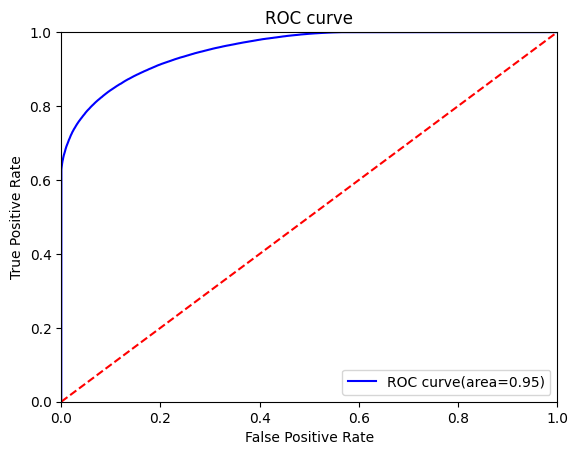

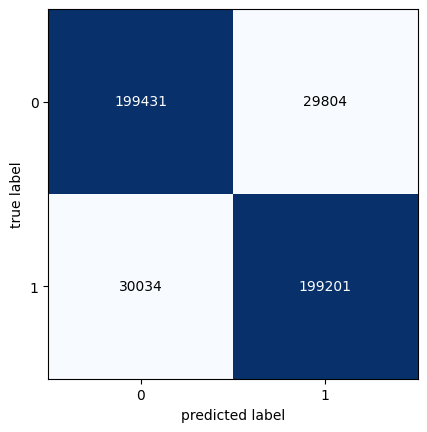

Threshold: 0.45
Accuracy: 0.8694832813488341
Recall: 0.8689816127554693
Precision: 0.8698543699919216
Beta_f2_score: 0.8691560240674727
==========================Val metrics================================


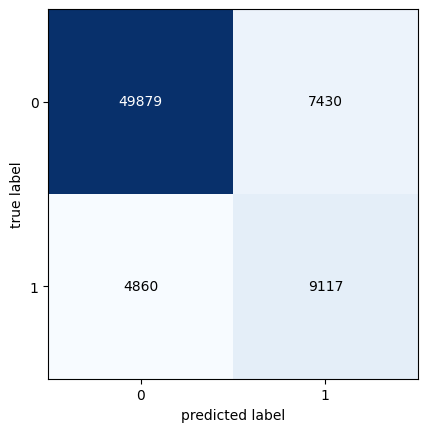

Threshold: 0.45
Accuracy: 0.8275958813792329
Recall: 0.6522858982614295
Precision: 0.5509760077355412
Beta_f2_score: 0.6291491270443723
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.224 + 1.395*pincode_11650 + 1.302*pincode_86630 + 0.295*term + 0.187*dti + 0.167*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.009*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.054*grade_F - 0.089*grade_D - 0.147*revol_bal - 0.181*total_acc - 0.22*broad_purpose_Business - 0.25*annual_inc - 0.26*initial_list_status_f - 0.278*broad_purpose_Education - 0.342*grade_C - 0.386*verification_status_Source Verified - 0.389*broad_purpose_Home - 0.411*broad_purpose_Energy - 0.552*application_type_DIRECT_PAY - 0.575*issue_d_Q_2 - 0.6*verification_status_Not Verified - 0.629*issue_d_Q_1 - 0.635*home_ownership_MORTGAGE - 0.638*issue_d_Q_3 - 0.663*earliest_cr_line_Q_3 - 0.675*earliest_cr_line_Q_2 - 

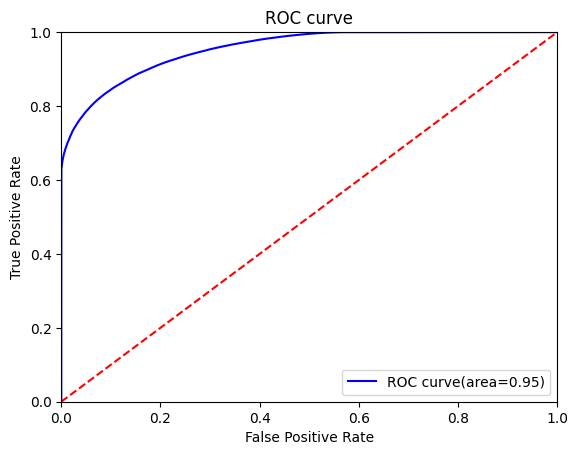

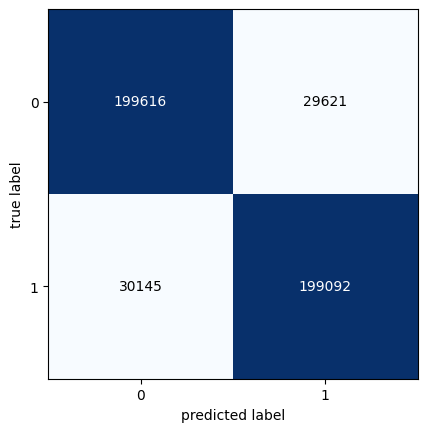

Threshold: 0.45
Accuracy: 0.8696414627656094
Recall: 0.8684985408114746
Precision: 0.8704883412836174
Beta_f2_score: 0.8688957728333251
==========================Val metrics================================


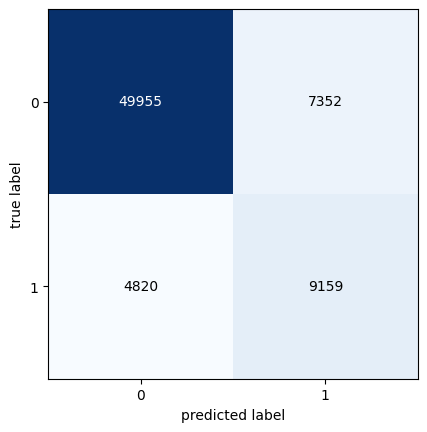

Threshold: 0.45
Accuracy: 0.8292511853659905
Recall: 0.6551970813362902
Precision: 0.5547210950275574
Beta_f2_score: 0.6322918248719401
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=10.862 + 1.729*pincode_11650 + 1.7*pincode_86630 + 0.295*term + 0.189*dti + 0.179*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.016*mort_acc - 0.028*pub_rec - 0.029*pub_rec_bankruptcies - 0.032*grade_F - 0.103*grade_D - 0.15*revol_bal - 0.195*broad_purpose_Business - 0.197*total_acc - 0.242*annual_inc - 0.253*initial_list_status_f - 0.347*grade_C - 0.372*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.473*broad_purpose_Education - 0.528*broad_purpose_Energy - 0.535*application_type_DIRECT_PAY - 0.587*verification_status_Not Verified - 0.606*issue_d_Q_2 - 0.637*home_ownership_MORTGAGE - 0.659*issue_d_Q_1 - 0.668*earliest_cr_line_Q_3 - 0.672*issue_d_Q_3 - 0.677*earliest_cr_line_Q_2 - 0.68*earliest_

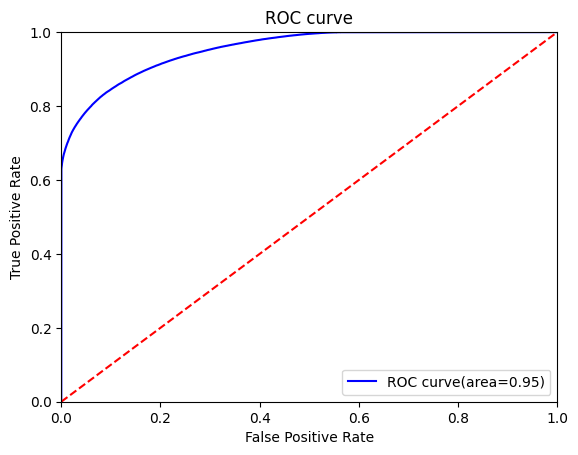

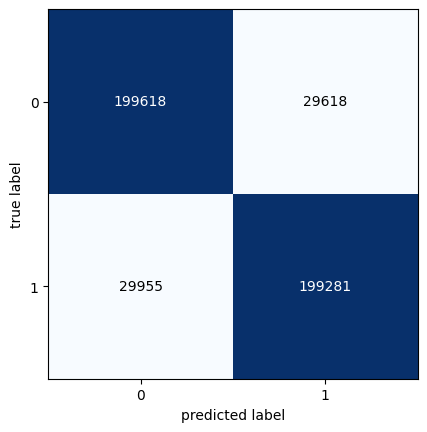

Threshold: 0.45
Accuracy: 0.8700618576488859
Recall: 0.8693268073077527
Precision: 0.8706066867919913
Beta_f2_score: 0.8695824820677877
==========================Val metrics================================


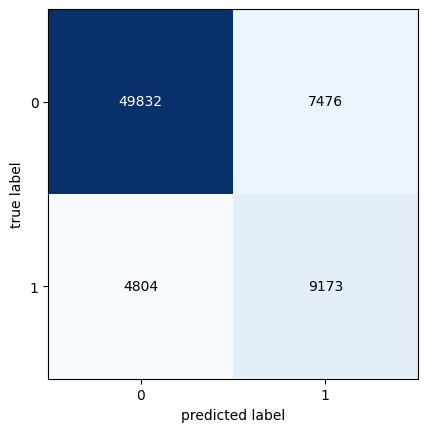

Threshold: 0.45
Accuracy: 0.8277337448271025
Recall: 0.6562924805036846
Precision: 0.550964021863175
Beta_f2_score: 0.6321237096351834
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=10.904 + 1.709*pincode_11650 + 1.654*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.012*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.053*grade_F - 0.096*grade_D - 0.131*broad_purpose_Business - 0.157*revol_bal - 0.192*total_acc - 0.25*annual_inc - 0.262*initial_list_status_f - 0.286*broad_purpose_Energy - 0.331*broad_purpose_Education - 0.339*grade_C - 0.387*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.579*issue_d_Q_2 - 0.582*application_type_DIRECT_PAY - 0.604*verification_status_Not Verified - 0.637*home_ownership_MORTGAGE - 0.639*issue_d_Q_1 - 0.656*issue_d_Q_3 - 0.67*earliest_cr_line_Q_3 - 0.68*earliest_cr_line_Q_2 - 0.

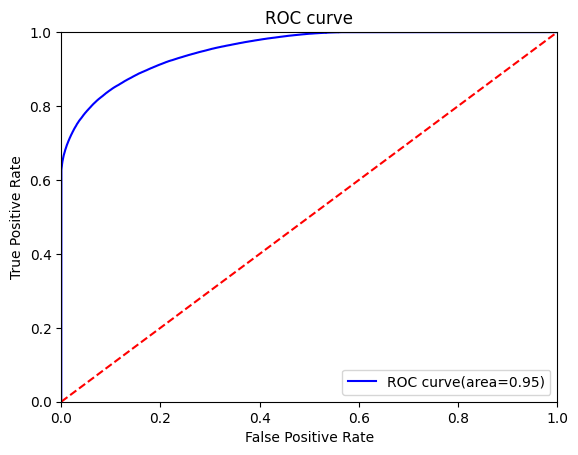

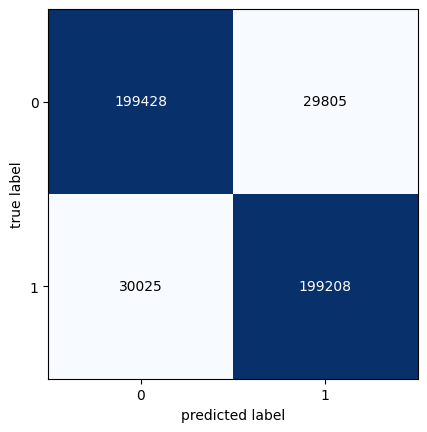

Threshold: 0.45
Accuracy: 0.8694995921180633
Recall: 0.8690197310160405
Precision: 0.8698545497417177
Beta_f2_score: 0.8691865665455147
==========================Val metrics================================


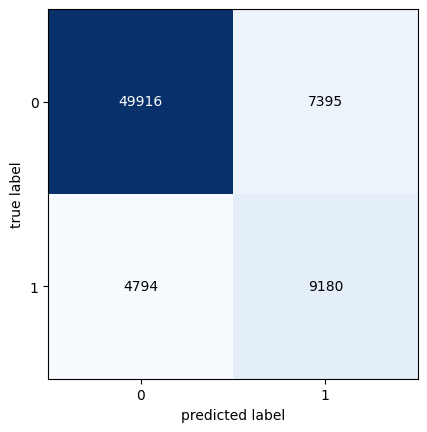

Threshold: 0.45
Accuracy: 0.8290103107245563
Recall: 0.656934306569343
Precision: 0.5538461538461539
Beta_f2_score: 0.633356790992259
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=10.858 + 1.772*pincode_11650 + 1.694*pincode_86630 + 0.287*term + 0.182*dti + 0.161*open_acc + 0.14*revol_util + 0.093*installment + 0.068*state + 0.019*emp_length + 0.006*grade_E + 0.003*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.028*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.217*broad_purpose_Business - 0.256*annual_inc - 0.273*initial_list_status_f - 0.343*grade_C - 0.369*verification_status_Source Verified - 0.385*broad_purpose_Home - 0.489*application_type_DIRECT_PAY - 0.598*verification_status_Not Verified - 0.607*issue_d_Q_2 - 0.634*issue_d_Q_1 - 0.635*home_ownership_MORTGAGE - 0.664*issue_d_Q_3 - 0.665*broad_purpose_Energy - 0.67*earliest_cr_line_Q_2 - 0.68*earliest_cr_line_Q_3 - 0.685*earliest_cr_line_Q_1 - 0.8

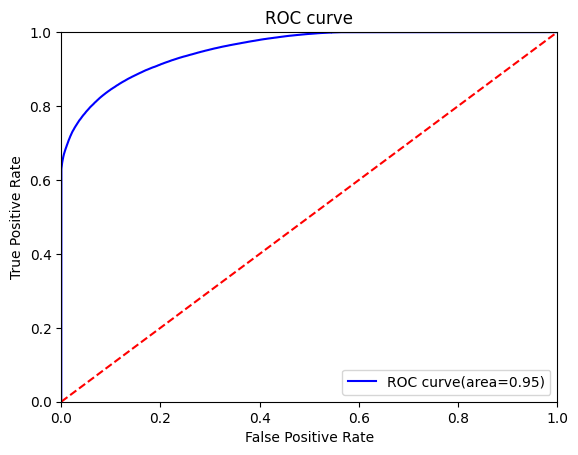

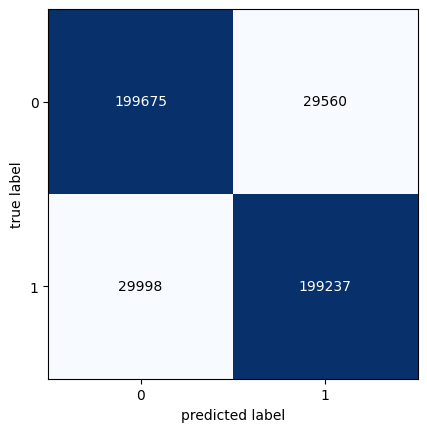

Threshold: 0.45
Accuracy: 0.870094008332061
Recall: 0.8691386568368704
Precision: 0.8708025017810548
Beta_f2_score: 0.8694709169730924
==========================Val metrics================================


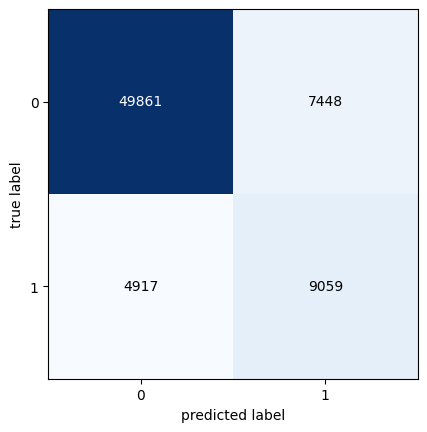

Threshold: 0.45
Accuracy: 0.8265413481097005
Recall: 0.6481825987406984
Precision: 0.5487974798570303
Beta_f2_score: 0.6255265084034195
==========================End of Folds================================
time taken(mins):  40.889749431610106
param_dict[best_estimator]:  LogisticRegression(penalty='l1', solver='liblinear')
param_dict[best_val_accuracy]:  0.8280264940813167
param_dict[best_val_f_betascore]:  0.6304895921894349
param_dict[best_val_recall]:  0.6537784730822891
param_dict[best_val_precision]:  0.5518609516658914
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=10.904 + 1.709*pincode_11650 + 1.654*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.012*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.053*grade_F - 0.096*grade_D - 0.131*broad_purpose_Business - 0.157*revol_bal - 0.192*total_acc - 0.25*annu

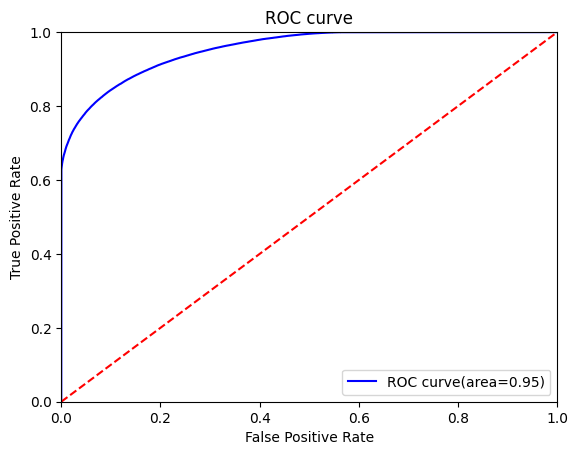

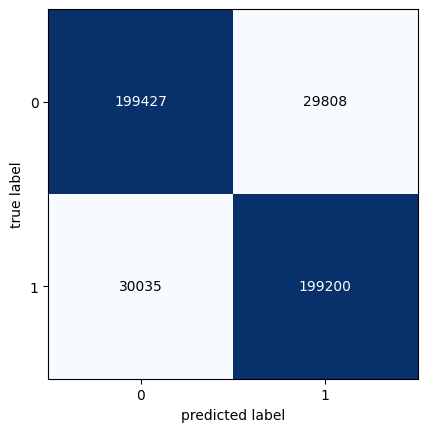

Threshold: 0.45
Accuracy: 0.869472375509848
Recall: 0.8689772504198748
Precision: 0.8698386082582268
Beta_f2_score: 0.8691493854869505
==========================Val metrics================================


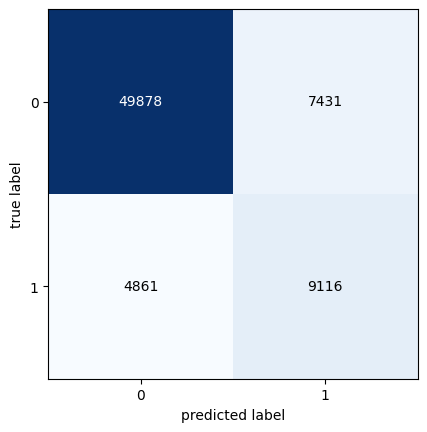

Threshold: 0.45
Accuracy: 0.8275678253794574
Recall: 0.6522143521499606
Precision: 0.5509155738200278
Beta_f2_score: 0.629080118694362
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.233 + 5.993*pincode_11650 + 5.9*pincode_86630 + 0.296*term + 0.187*dti + 0.167*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.009*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.054*grade_F - 0.09*grade_D - 0.147*revol_bal - 0.181*total_acc - 0.222*broad_purpose_Business - 0.25*annual_inc - 0.26*initial_list_status_f - 0.342*grade_C - 0.361*broad_purpose_Education - 0.386*verification_status_Source Verified - 0.39*broad_purpose_Home - 0.459*broad_purpose_Energy - 0.575*issue_d_Q_2 - 0.591*application_type_DIRECT_PAY - 0.601*verification_status_Not Verified - 0.629*issue_d_Q_1 - 0.635*home_ownership_MORTGAGE - 0.639*issue_d_Q_3 - 0.664*earliest_cr_line_Q_3 - 0.675*earliest_cr_line_Q_2 - 0.

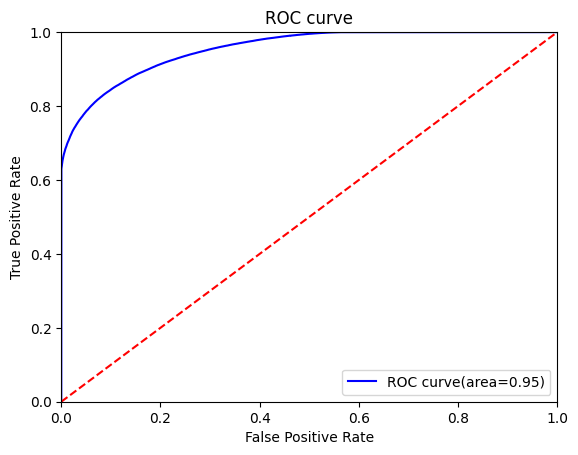

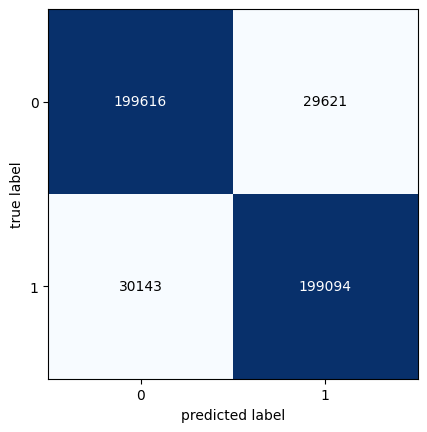

Threshold: 0.45
Accuracy: 0.8696458250631443
Recall: 0.8685072654065443
Precision: 0.8704894737992699
Beta_f2_score: 0.868902984560032
==========================Val metrics================================


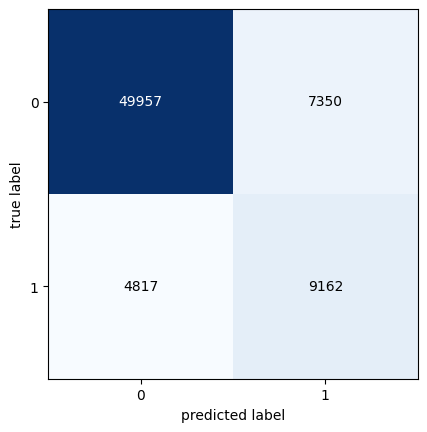

Threshold: 0.45
Accuracy: 0.8293213253654294
Recall: 0.6554116889620144
Precision: 0.5548691860465116
Beta_f2_score: 0.6324901971613188
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.19 + 6.01*pincode_11650 + 5.98*pincode_86630 + 0.295*term + 0.19*dti + 0.179*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.016*mort_acc - 0.028*pub_rec - 0.029*pub_rec_bankruptcies - 0.033*grade_F - 0.104*grade_D - 0.15*revol_bal - 0.197*total_acc - 0.197*broad_purpose_Business - 0.242*annual_inc - 0.253*initial_list_status_f - 0.347*grade_C - 0.372*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.553*broad_purpose_Education - 0.576*application_type_DIRECT_PAY - 0.576*broad_purpose_Energy - 0.587*verification_status_Not Verified - 0.607*issue_d_Q_2 - 0.638*home_ownership_MORTGAGE - 0.659*issue_d_Q_1 - 0.668*earliest_cr_line_Q_3 - 0.673*issue_d_Q_3 - 0.678*earliest_cr_line_Q_2 - 0.68*earliest_cr

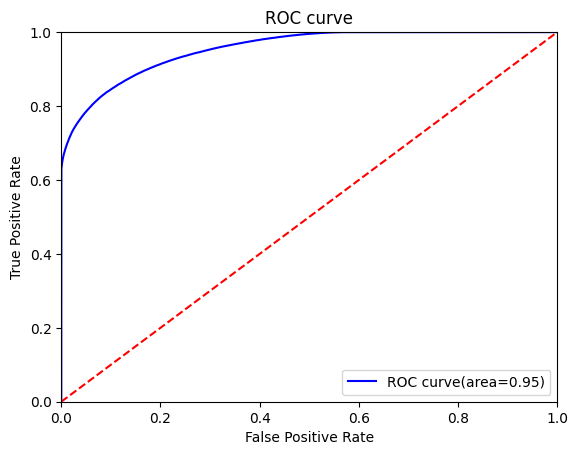

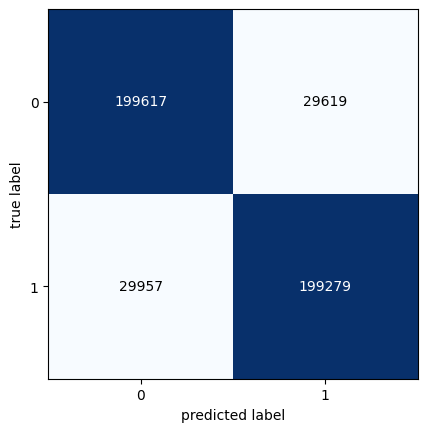

Threshold: 0.45
Accuracy: 0.870055314174039
Recall: 0.8693180826746235
Precision: 0.8706017527457645
Beta_f2_score: 0.8695745137636777
==========================Val metrics================================


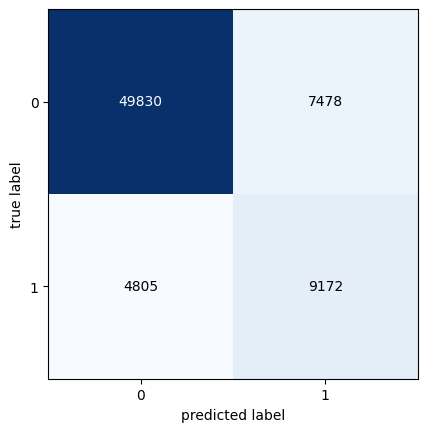

Threshold: 0.45
Accuracy: 0.8276916602370765
Recall: 0.6562209343922157
Precision: 0.5508708708708708
Beta_f2_score: 0.6320460872681165
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.237 + 5.984*pincode_11650 + 5.929*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.133*broad_purpose_Business - 0.157*revol_bal - 0.193*total_acc - 0.251*annual_inc - 0.262*initial_list_status_f - 0.337*broad_purpose_Energy - 0.34*grade_C - 0.387*verification_status_Source Verified - 0.41*broad_purpose_Education - 0.413*broad_purpose_Home - 0.579*issue_d_Q_2 - 0.604*verification_status_Not Verified - 0.625*application_type_DIRECT_PAY - 0.638*home_ownership_MORTGAGE - 0.639*issue_d_Q_1 - 0.656*issue_d_Q_3 - 0.67*earliest_cr_line_Q_3 - 0.681*earliest_cr_line_Q_2 - 0

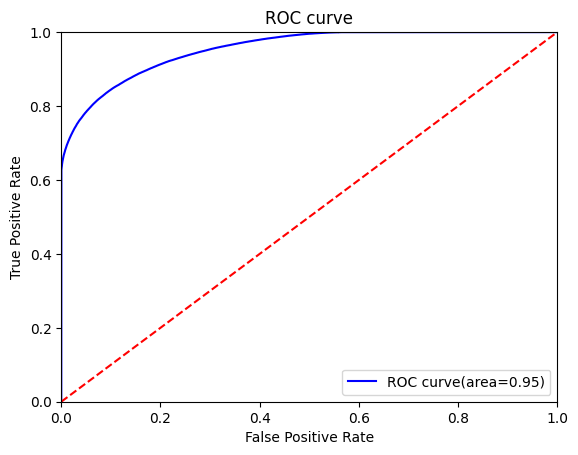

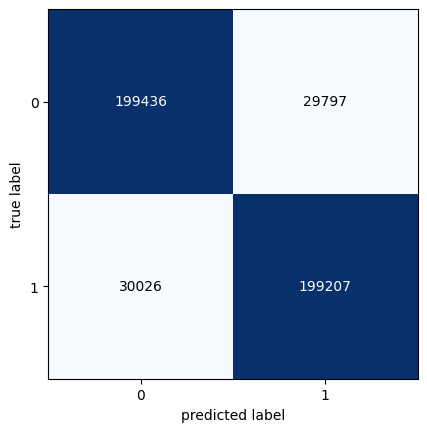

Threshold: 0.45
Accuracy: 0.8695148604258549
Recall: 0.8690153686423857
Precision: 0.8698843688319855
Beta_f2_score: 0.8691890297538432
==========================Val metrics================================


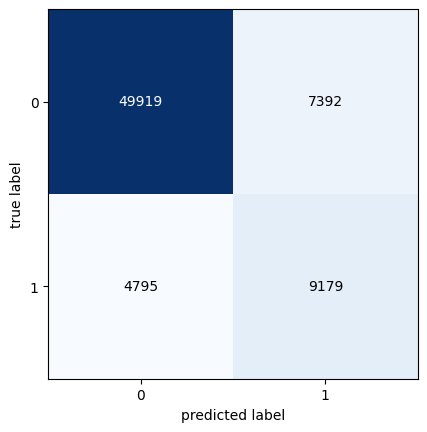

Threshold: 0.45
Accuracy: 0.829038367117907
Recall: 0.6568627450980392
Precision: 0.5539194979180496
Beta_f2_score: 0.6333227538051803
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.489 + 5.751*pincode_11650 + 5.673*pincode_86630 + 0.287*term + 0.182*dti + 0.162*open_acc + 0.14*revol_util + 0.093*installment + 0.068*state + 0.019*emp_length + 0.007*grade_E + 0.004*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.028*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.219*broad_purpose_Business - 0.256*annual_inc - 0.274*initial_list_status_f - 0.343*grade_C - 0.37*verification_status_Source Verified - 0.386*broad_purpose_Home - 0.526*application_type_DIRECT_PAY - 0.598*verification_status_Not Verified - 0.608*issue_d_Q_2 - 0.635*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.665*issue_d_Q_3 - 0.671*earliest_cr_line_Q_2 - 0.68*earliest_cr_line_Q_3 - 0.685*earliest_cr_line_Q_1 - 0.721*broad_purpose_Energy - 0.

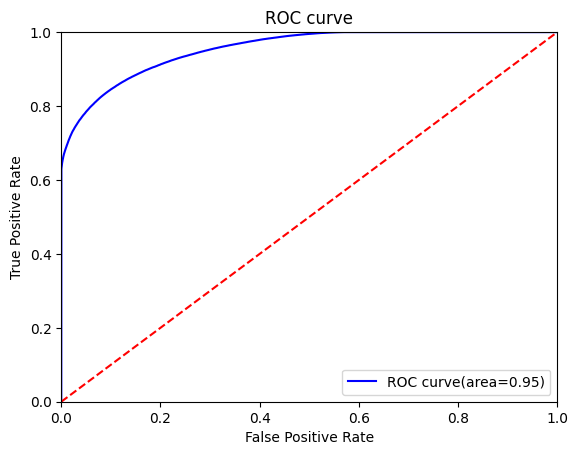

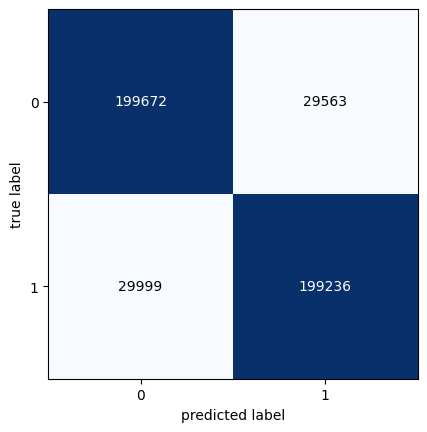

Threshold: 0.45
Accuracy: 0.870085283660872
Recall: 0.869134294501276
Precision: 0.8707905191893321
Beta_f2_score: 0.8694650352305369
==========================Val metrics================================


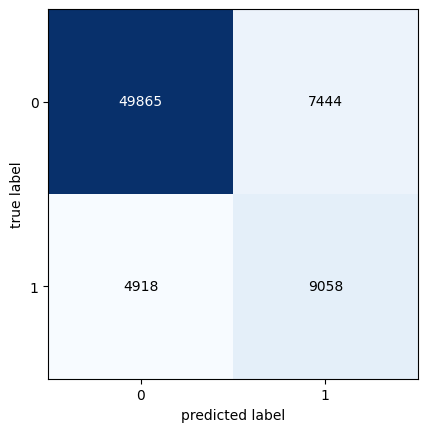

Threshold: 0.45
Accuracy: 0.8265834326997265
Recall: 0.6481110475100171
Precision: 0.5489031632529391
Beta_f2_score: 0.6255006491174764
==========================End of Folds================================
time taken(mins):  11.87026667992274
param_dict[best_estimator]:  LogisticRegression(penalty='l1', solver='liblinear')
param_dict[best_val_accuracy]:  0.8280264940813167
param_dict[best_val_f_betascore]:  0.6304895921894349
param_dict[best_val_recall]:  0.6537784730822891
param_dict[best_val_precision]:  0.5518609516658914
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=10.904 + 1.709*pincode_11650 + 1.654*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.012*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.053*grade_F - 0.096*grade_D - 0.131*broad_purpose_Business - 0.157*revol_bal - 0.192*total_acc - 0.25*annua

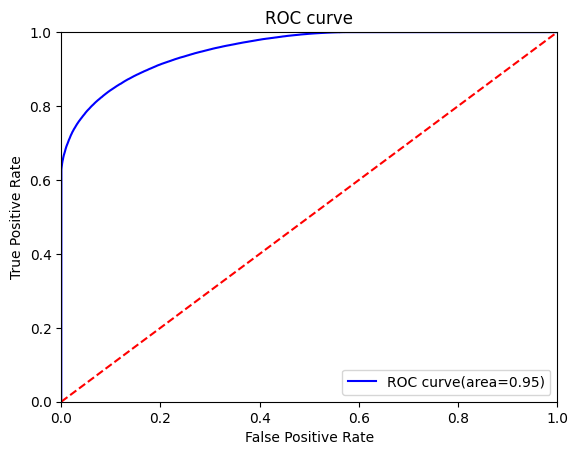

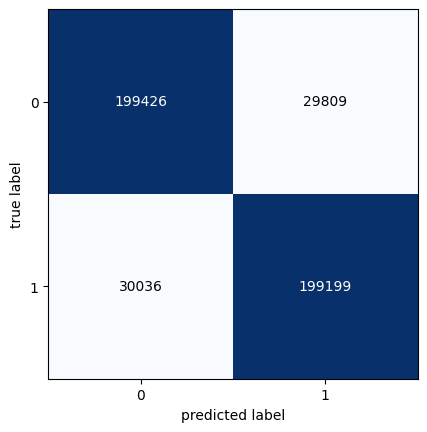

Threshold: 0.45
Accuracy: 0.8694680131742535
Recall: 0.8689728880842803
Precision: 0.8698342415985467
Beta_f2_score: 0.8691450222872242
==========================Val metrics================================


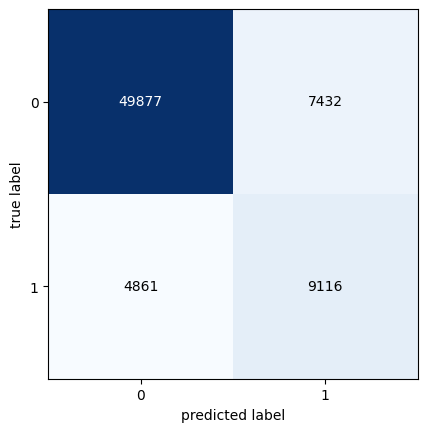

Threshold: 0.45
Accuracy: 0.8275537973795696
Recall: 0.6522143521499606
Precision: 0.5508822818467488
Beta_f2_score: 0.6290714364579882
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.225 + 10.606*pincode_11650 + 10.513*pincode_86630 + 0.296*term + 0.187*dti + 0.167*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.009*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.054*grade_F - 0.09*grade_D - 0.148*revol_bal - 0.181*total_acc - 0.222*broad_purpose_Business - 0.25*annual_inc - 0.26*initial_list_status_f - 0.342*grade_C - 0.362*broad_purpose_Education - 0.386*verification_status_Source Verified - 0.39*broad_purpose_Home - 0.459*broad_purpose_Energy - 0.575*issue_d_Q_2 - 0.592*application_type_DIRECT_PAY - 0.6*verification_status_Not Verified - 0.629*issue_d_Q_1 - 0.635*home_ownership_MORTGAGE - 0.639*issue_d_Q_3 - 0.664*earliest_cr_line_Q_3 - 0.675*earliest_cr_line_Q_2 -

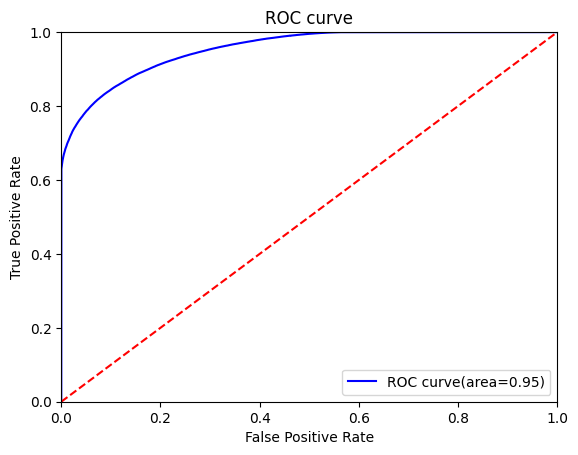

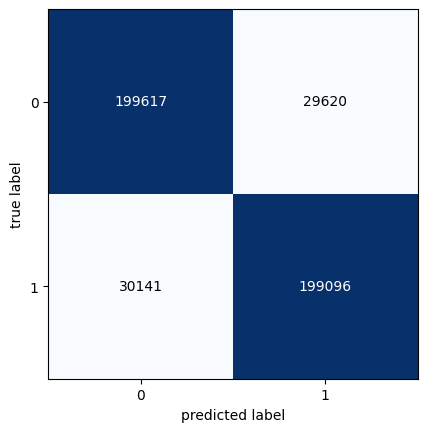

Threshold: 0.45
Accuracy: 0.8696523685094466
Recall: 0.8685159900016141
Precision: 0.8704944122842302
Beta_f2_score: 0.8689109546952684
==========================Val metrics================================


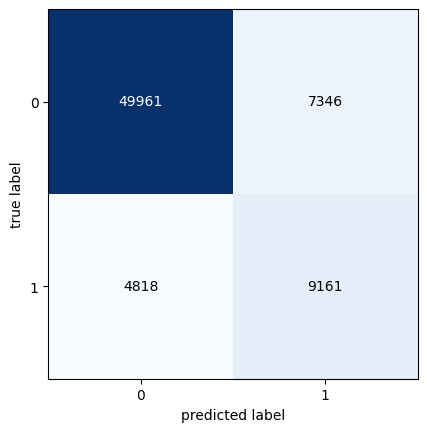

Threshold: 0.45
Accuracy: 0.8293634093650927
Recall: 0.6553401530867731
Precision: 0.5549766765614588
Beta_f2_score: 0.632464824710382
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.475 + 10.332*pincode_11650 + 10.302*pincode_86630 + 0.295*term + 0.19*dti + 0.179*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.016*mort_acc - 0.028*pub_rec - 0.029*pub_rec_bankruptcies - 0.033*grade_F - 0.104*grade_D - 0.15*revol_bal - 0.197*total_acc - 0.197*broad_purpose_Business - 0.242*annual_inc - 0.253*initial_list_status_f - 0.347*grade_C - 0.373*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.553*broad_purpose_Education - 0.576*application_type_DIRECT_PAY - 0.577*broad_purpose_Energy - 0.587*verification_status_Not Verified - 0.607*issue_d_Q_2 - 0.638*home_ownership_MORTGAGE - 0.66*issue_d_Q_1 - 0.669*earliest_cr_line_Q_3 - 0.673*issue_d_Q_3 - 0.678*earliest_cr_line_Q_2 - 0.681*earlies

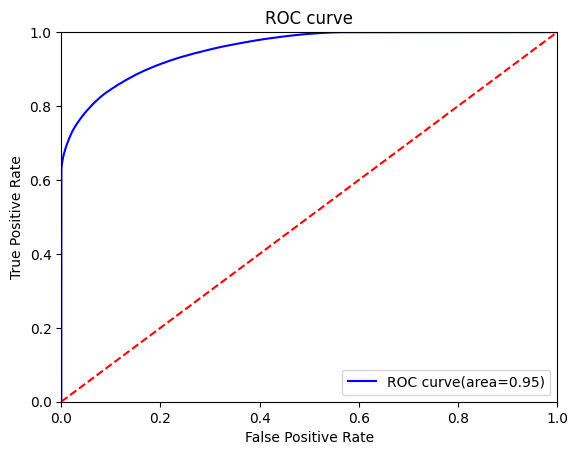

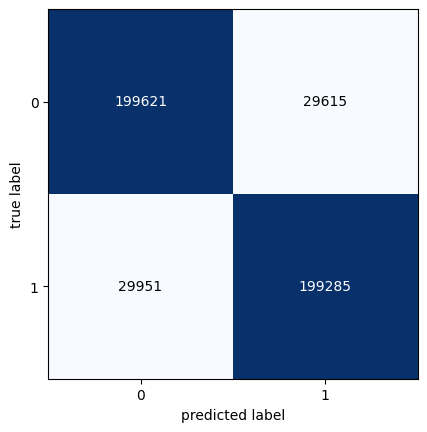

Threshold: 0.45
Accuracy: 0.8700771257568619
Recall: 0.869344256574011
Precision: 0.8706203582350371
Beta_f2_score: 0.8695991775494746
==========================Val metrics================================


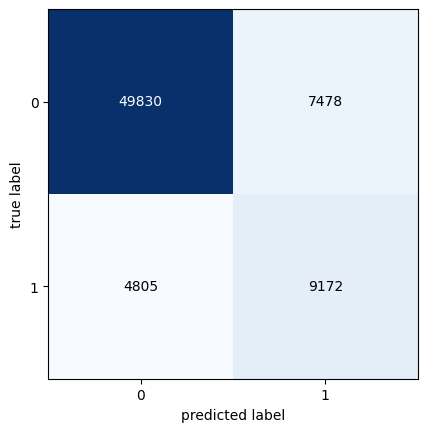

Threshold: 0.45
Accuracy: 0.8276916602370765
Recall: 0.6562209343922157
Precision: 0.5508708708708708
Beta_f2_score: 0.6320460872681165
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.335 + 10.493*pincode_11650 + 10.437*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.133*broad_purpose_Business - 0.157*revol_bal - 0.193*total_acc - 0.251*annual_inc - 0.262*initial_list_status_f - 0.338*broad_purpose_Energy - 0.34*grade_C - 0.387*verification_status_Source Verified - 0.411*broad_purpose_Education - 0.413*broad_purpose_Home - 0.579*issue_d_Q_2 - 0.604*verification_status_Not Verified - 0.626*application_type_DIRECT_PAY - 0.638*home_ownership_MORTGAGE - 0.639*issue_d_Q_1 - 0.657*issue_d_Q_3 - 0.67*earliest_cr_line_Q_3 - 0.681*earliest_cr_line_Q_2 

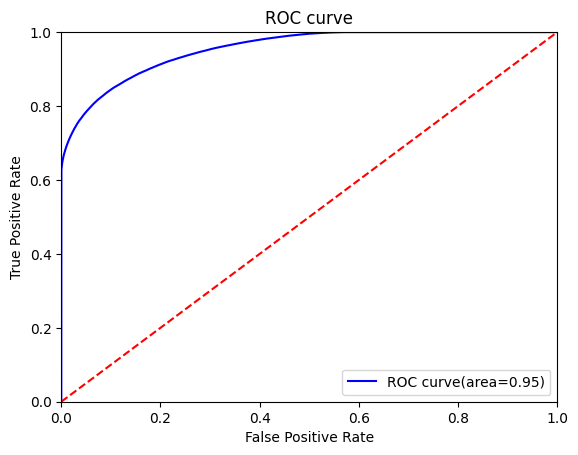

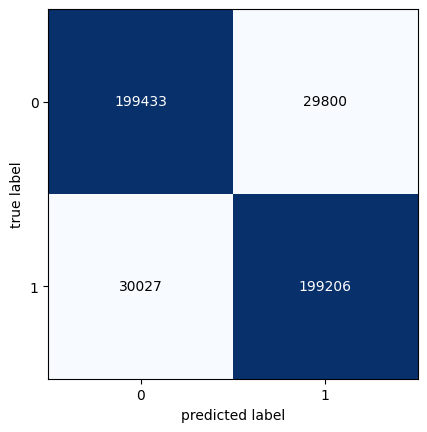

Threshold: 0.45
Accuracy: 0.8695061356785454
Recall: 0.869011006268731
Precision: 0.869872405089823
Beta_f2_score: 0.8691831495246689
==========================Val metrics================================


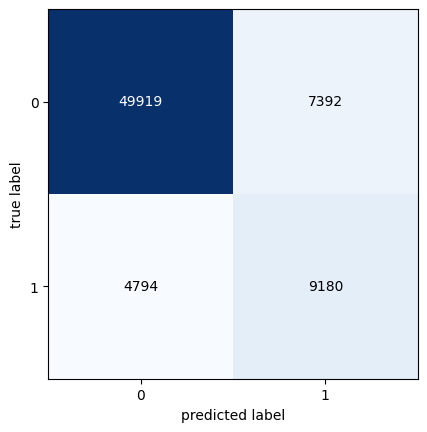

Threshold: 0.45
Accuracy: 0.8290523953145823
Recall: 0.656934306569343
Precision: 0.55394641564084
Beta_f2_score: 0.6333830104321907
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.417 + 10.427*pincode_11650 + 10.349*pincode_86630 + 0.287*term + 0.182*dti + 0.162*open_acc + 0.14*revol_util + 0.093*installment + 0.068*state + 0.019*emp_length + 0.007*grade_E + 0.004*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.028*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.219*broad_purpose_Business - 0.256*annual_inc - 0.273*initial_list_status_f - 0.343*grade_C - 0.37*verification_status_Source Verified - 0.386*broad_purpose_Home - 0.527*application_type_DIRECT_PAY - 0.598*verification_status_Not Verified - 0.607*issue_d_Q_2 - 0.635*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.665*issue_d_Q_3 - 0.671*earliest_cr_line_Q_2 - 0.68*earliest_cr_line_Q_3 - 0.685*earliest_cr_line_Q_1 - 0.721*broad_purpose_Energy - 0.

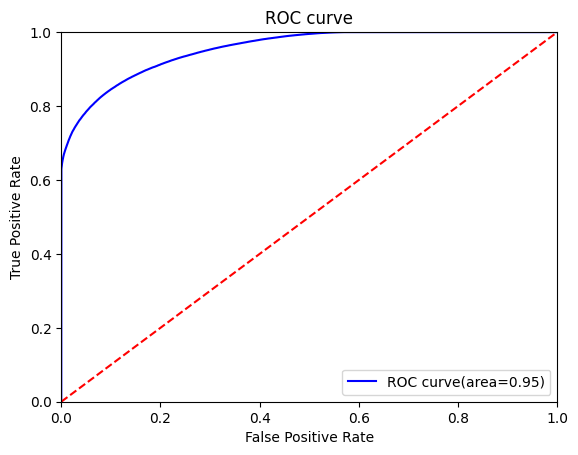

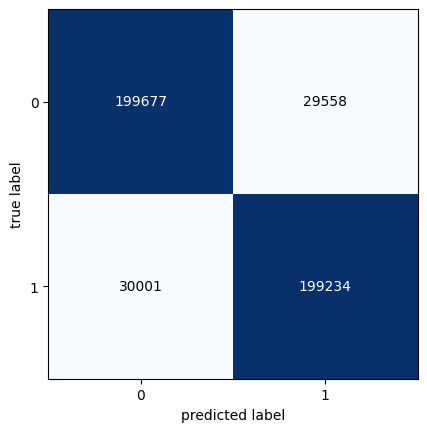

Threshold: 0.45
Accuracy: 0.8700918271642637
Recall: 0.869125569830087
Precision: 0.8708084198748208
Beta_f2_score: 0.8694616192966593
==========================Val metrics================================


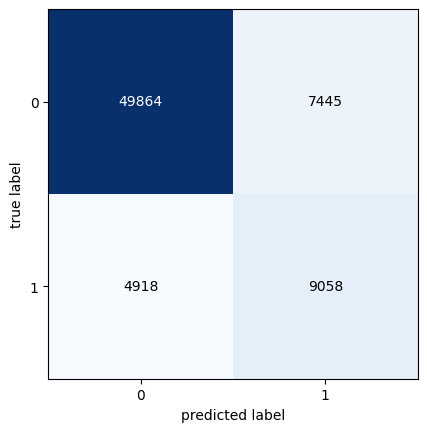

Threshold: 0.45
Accuracy: 0.8265694045030512
Recall: 0.6481110475100171
Precision: 0.5488699024419802
Beta_f2_score: 0.6254920104409795
==========================End of Folds================================
time taken(mins):  12.369935095310211
param_dict[best_estimator]:  LogisticRegression(C=10000.0, penalty='l1', solver='liblinear')
param_dict[best_val_accuracy]:  0.8280461333598744
param_dict[best_val_f_betascore]:  0.6304914738619314
param_dict[best_val_recall]:  0.6537641587416619
param_dict[best_val_precision]:  0.5519092294723797
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=11.335 + 10.493*pincode_11650 + 10.437*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.133*broad_purpose_Business - 0.157*revol_bal - 0.193*total_ac

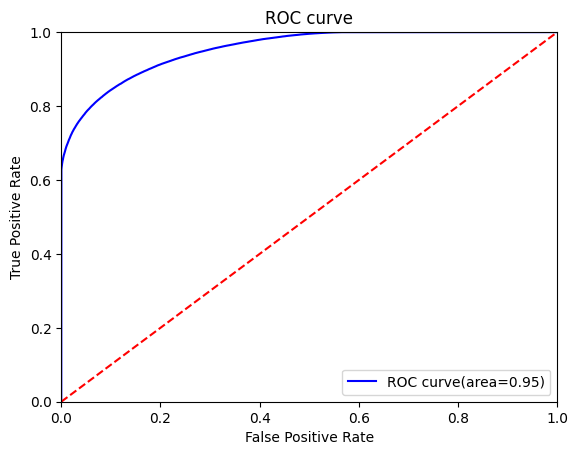

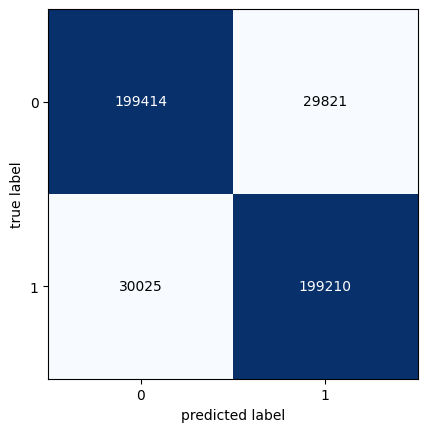

Threshold: 0.45
Accuracy: 0.8694658320064562
Recall: 0.8690208737758196
Precision: 0.8697949185918064
Beta_f2_score: 0.8691755725057615
==========================Val metrics================================


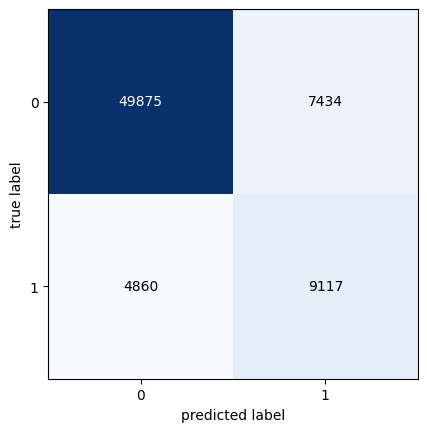

Threshold: 0.45
Accuracy: 0.8275397693796819
Recall: 0.6522858982614295
Precision: 0.5508428493746601
Beta_f2_score: 0.6291143957272389
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.454 + 2.621*pincode_11650 + 2.559*pincode_86630 + 0.295*term + 0.187*dti + 0.166*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.008*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.054*grade_F - 0.09*grade_D - 0.147*revol_bal - 0.181*total_acc - 0.222*broad_purpose_Business - 0.249*annual_inc - 0.26*initial_list_status_f - 0.337*broad_purpose_Education - 0.341*grade_C - 0.385*verification_status_Source Verified - 0.39*broad_purpose_Home - 0.432*broad_purpose_Energy - 0.56*application_type_DIRECT_PAY - 0.574*issue_d_Q_2 - 0.6*verification_status_Not Verified - 0.628*issue_d_Q_1 - 0.634*home_ownership_MORTGAGE - 0.638*issue_d_Q_3 - 0.663*earliest_cr_line_Q_3 - 0.674*earliest_cr_line_Q_2 - 0.

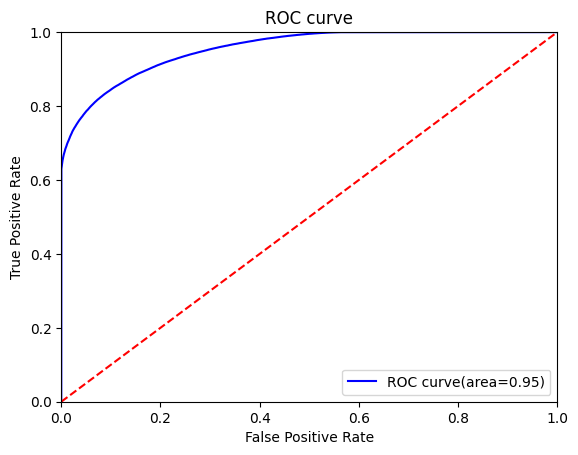

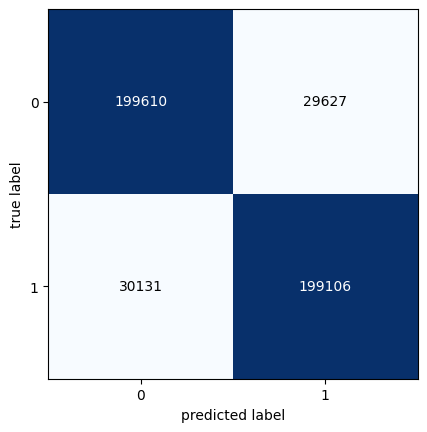

Threshold: 0.45
Accuracy: 0.8696589119557488
Recall: 0.8685596129769627
Precision: 0.8704734340912768
Beta_f2_score: 0.8689417036679494
==========================Val metrics================================


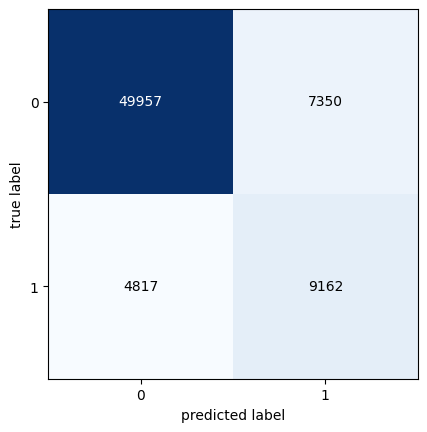

Threshold: 0.45
Accuracy: 0.8293213253654294
Recall: 0.6554116889620144
Precision: 0.5548691860465116
Beta_f2_score: 0.6324901971613188
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.455 + 2.358*pincode_11650 + 2.34*pincode_86630 + 0.294*term + 0.189*dti + 0.179*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.016*mort_acc - 0.027*pub_rec - 0.029*pub_rec_bankruptcies - 0.033*grade_F - 0.104*grade_D - 0.15*revol_bal - 0.197*total_acc - 0.197*broad_purpose_Business - 0.241*annual_inc - 0.252*initial_list_status_f - 0.347*grade_C - 0.372*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.495*broad_purpose_Education - 0.578*broad_purpose_Energy - 0.586*verification_status_Not Verified - 0.602*application_type_DIRECT_PAY - 0.606*issue_d_Q_2 - 0.637*home_ownership_MORTGAGE - 0.658*issue_d_Q_1 - 0.668*earliest_cr_line_Q_3 - 0.672*issue_d_Q_3 - 0.677*earliest_cr_line_Q_2 - 0.68*earliest_

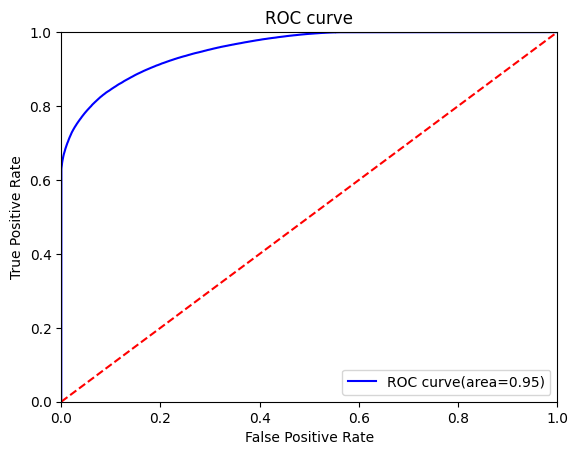

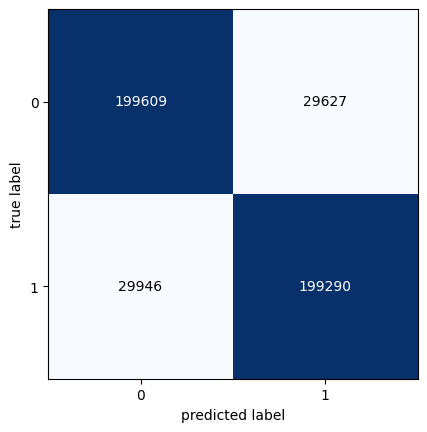

Threshold: 0.45
Accuracy: 0.8700618576488859
Recall: 0.869366068156834
Precision: 0.8705775455732864
Beta_f2_score: 0.8696080938263892
==========================Val metrics================================


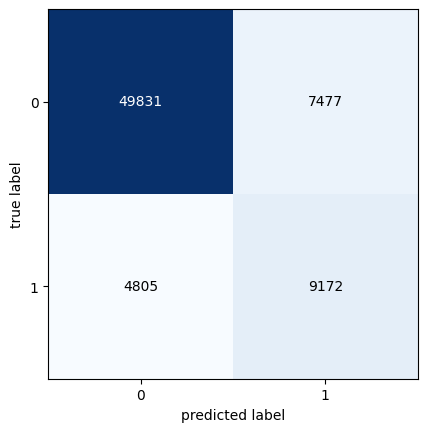

Threshold: 0.45
Accuracy: 0.8277056884337518
Recall: 0.6562209343922157
Precision: 0.5509039581956874
Beta_f2_score: 0.6320547982965116
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.474 + 2.603*pincode_11650 + 2.561*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.137*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.025*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.134*broad_purpose_Business - 0.156*revol_bal - 0.192*total_acc - 0.25*annual_inc - 0.261*initial_list_status_f - 0.319*broad_purpose_Energy - 0.34*grade_C - 0.384*broad_purpose_Education - 0.387*verification_status_Source Verified - 0.413*broad_purpose_Home - 0.578*issue_d_Q_2 - 0.59*application_type_DIRECT_PAY - 0.603*verification_status_Not Verified - 0.637*home_ownership_MORTGAGE - 0.638*issue_d_Q_1 - 0.655*issue_d_Q_3 - 0.669*earliest_cr_line_Q_3 - 0.68*earliest_cr_line_Q_2 - 0.6

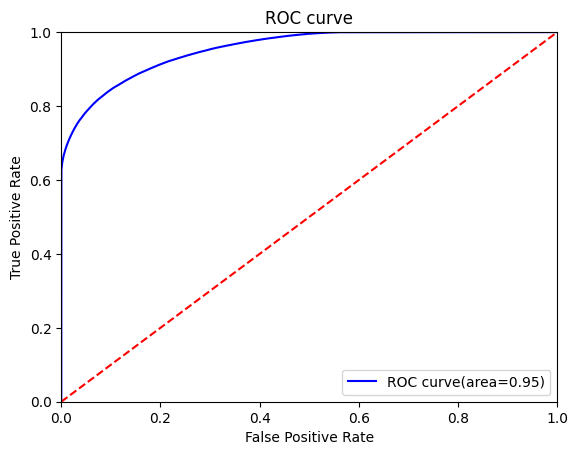

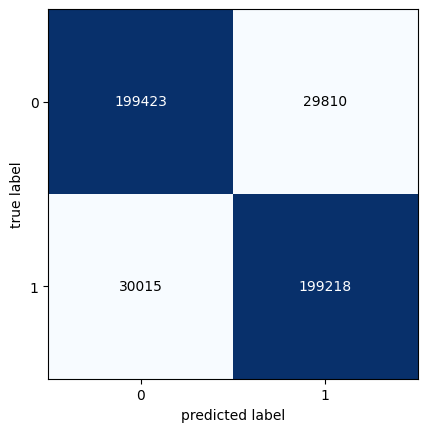

Threshold: 0.45
Accuracy: 0.8695104980522002
Recall: 0.869063354752588
Precision: 0.8698412421188676
Beta_f2_score: 0.8692188209012531
==========================Val metrics================================


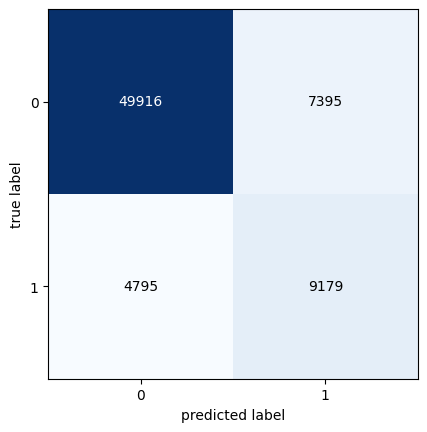

Threshold: 0.45
Accuracy: 0.828996282527881
Recall: 0.6568627450980392
Precision: 0.5538192349463015
Beta_f2_score: 0.6332965364978612
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.481 + 2.362*pincode_11650 + 2.311*pincode_86630 + 0.287*term + 0.182*dti + 0.161*open_acc + 0.14*revol_util + 0.093*installment + 0.067*state + 0.019*emp_length + 0.006*grade_E + 0.004*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.028*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.219*broad_purpose_Business - 0.255*annual_inc - 0.273*initial_list_status_f - 0.343*grade_C - 0.37*verification_status_Source Verified - 0.386*broad_purpose_Home - 0.559*application_type_DIRECT_PAY - 0.597*verification_status_Not Verified - 0.606*issue_d_Q_2 - 0.633*issue_d_Q_1 - 0.634*home_ownership_MORTGAGE - 0.664*issue_d_Q_3 - 0.67*earliest_cr_line_Q_2 - 0.679*earliest_cr_line_Q_3 - 0.684*earliest_cr_line_Q_1 - 0.694*broad_purpose_Energy - 0.8

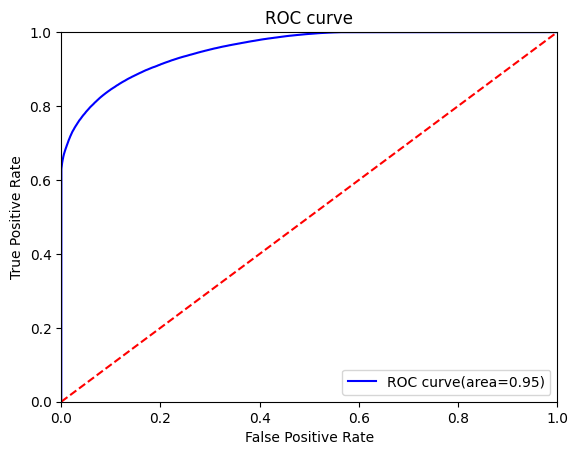

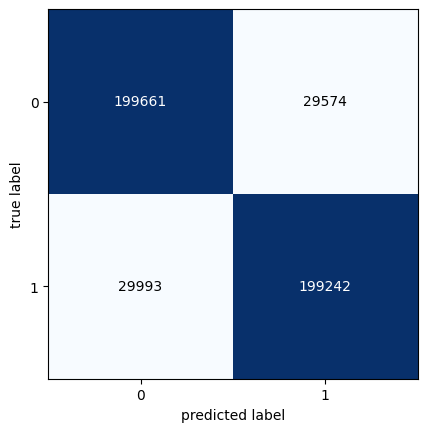

Threshold: 0.45
Accuracy: 0.8700743778218858
Recall: 0.8691604685148429
Precision: 0.8707520453115167
Beta_f2_score: 0.8694783182457696
==========================Val metrics================================


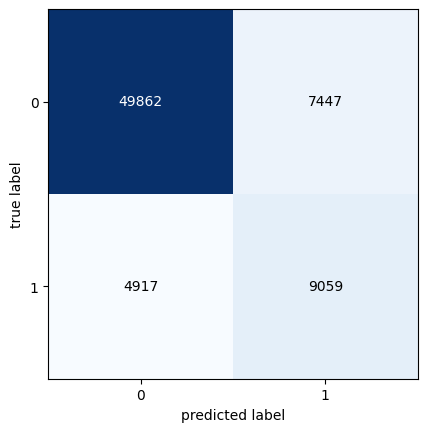

Threshold: 0.45
Accuracy: 0.8265553763063758
Recall: 0.6481825987406984
Precision: 0.5488307282200412
Beta_f2_score: 0.6255351470791326
==========================End of Folds================================
time taken(mins):  5.083092510700226
param_dict[best_estimator]:  LogisticRegression(solver='liblinear')
param_dict[best_val_accuracy]:  0.8280236884026241
param_dict[best_val_f_betascore]:  0.6304982149524127
param_dict[best_val_recall]:  0.6537927730908795
param_dict[best_val_precision]:  0.5518531913566405
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.474 + 2.603*pincode_11650 + 2.561*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.137*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.025*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.134*broad_purpose_Business - 0.156*revol_bal - 0.192*total_acc - 0.25*annual_inc - 0.261*i

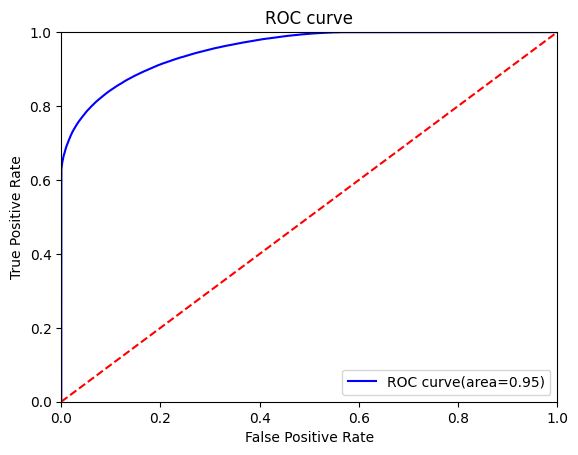

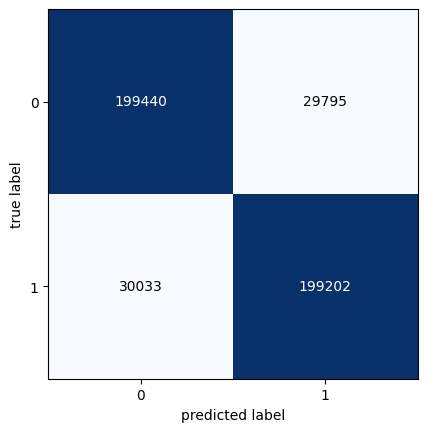

Threshold: 0.45
Accuracy: 0.8695050930268066
Recall: 0.8689859750910638
Precision: 0.8698891251850461
Beta_f2_score: 0.8691664550494486
==========================Val metrics================================


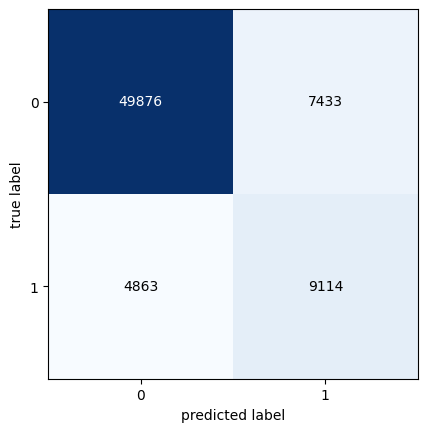

Threshold: 0.45
Accuracy: 0.8275117133799063
Recall: 0.652071259927023
Precision: 0.550794705989001
Beta_f2_score: 0.6289421019943413
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.697 + 3.294*pincode_11650 + 3.22*pincode_86630 + 0.296*term + 0.187*dti + 0.167*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.009*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.055*grade_F - 0.09*grade_D - 0.148*revol_bal - 0.181*total_acc - 0.222*broad_purpose_Business - 0.25*annual_inc - 0.261*initial_list_status_f - 0.342*grade_C - 0.355*broad_purpose_Education - 0.386*verification_status_Source Verified - 0.389*broad_purpose_Home - 0.458*broad_purpose_Energy - 0.576*issue_d_Q_2 - 0.591*application_type_DIRECT_PAY - 0.601*verification_status_Not Verified - 0.63*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.639*issue_d_Q_3 - 0.664*earliest_cr_line_Q_3 - 0.676*earliest_cr_line_Q_2 - 0

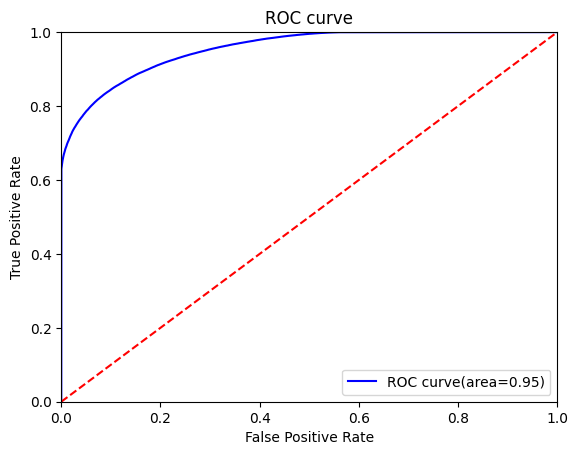

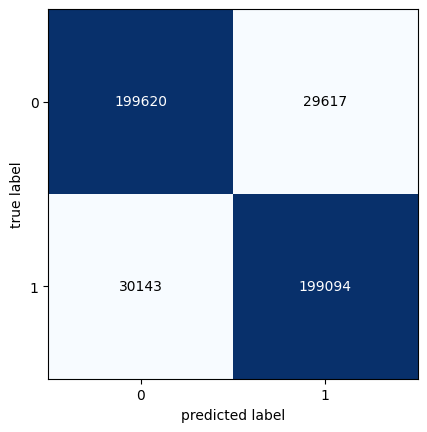

Threshold: 0.45
Accuracy: 0.869654549658214
Recall: 0.8685072654065443
Precision: 0.8705046980687418
Beta_f2_score: 0.8689060182829271
==========================Val metrics================================


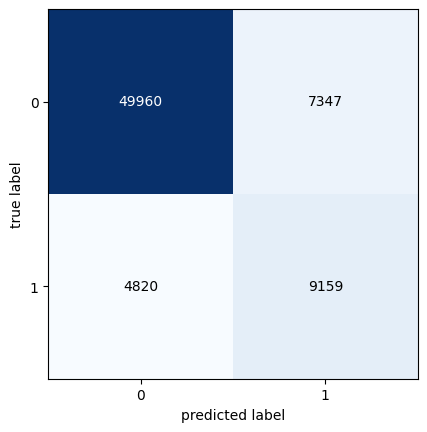

Threshold: 0.45
Accuracy: 0.8293213253654294
Recall: 0.6551970813362902
Precision: 0.554889131225009
Beta_f2_score: 0.6323354781696171
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.694 + 3.274*pincode_11650 + 3.251*pincode_86630 + 0.295*term + 0.19*dti + 0.179*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.015*mort_acc - 0.028*pub_rec - 0.029*pub_rec_bankruptcies - 0.033*grade_F - 0.104*grade_D - 0.15*revol_bal - 0.197*total_acc - 0.198*broad_purpose_Business - 0.242*annual_inc - 0.253*initial_list_status_f - 0.348*grade_C - 0.373*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.545*broad_purpose_Education - 0.576*application_type_DIRECT_PAY - 0.576*broad_purpose_Energy - 0.588*verification_status_Not Verified - 0.607*issue_d_Q_2 - 0.639*home_ownership_MORTGAGE - 0.66*issue_d_Q_1 - 0.669*earliest_cr_line_Q_3 - 0.673*issue_d_Q_3 - 0.678*earliest_cr_line_Q_2 - 0.681*earliest_

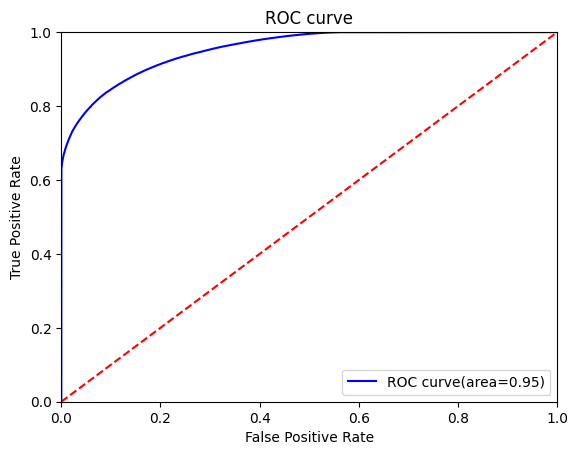

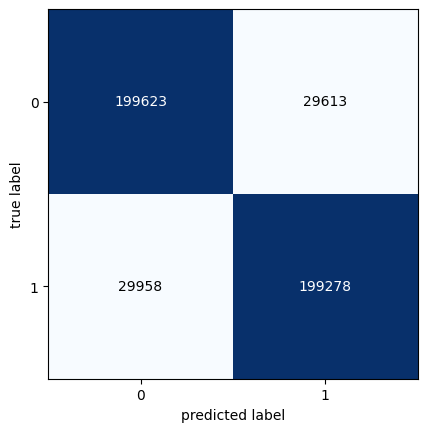

Threshold: 0.45
Accuracy: 0.8700662199654504
Recall: 0.869313720358059
Precision: 0.8706240088076858
Beta_f2_score: 0.8695754624356912
==========================Val metrics================================


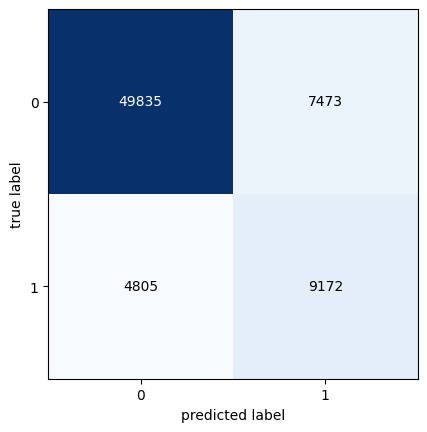

Threshold: 0.45
Accuracy: 0.8277618012204531
Recall: 0.6562209343922157
Precision: 0.5510363472514268
Beta_f2_score: 0.6320896448113792
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.726 + 3.272*pincode_11650 + 3.222*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.133*broad_purpose_Business - 0.157*revol_bal - 0.193*total_acc - 0.251*annual_inc - 0.262*initial_list_status_f - 0.337*broad_purpose_Energy - 0.34*grade_C - 0.388*verification_status_Source Verified - 0.403*broad_purpose_Education - 0.413*broad_purpose_Home - 0.58*issue_d_Q_2 - 0.605*verification_status_Not Verified - 0.625*application_type_DIRECT_PAY - 0.638*home_ownership_MORTGAGE - 0.64*issue_d_Q_1 - 0.657*issue_d_Q_3 - 0.671*earliest_cr_line_Q_3 - 0.682*earliest_cr_line_Q_2 - 0

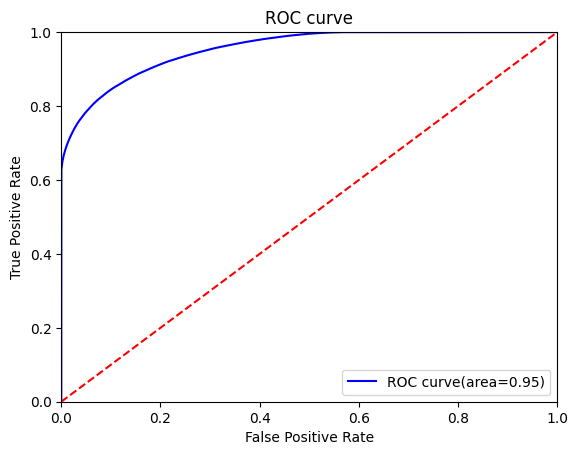

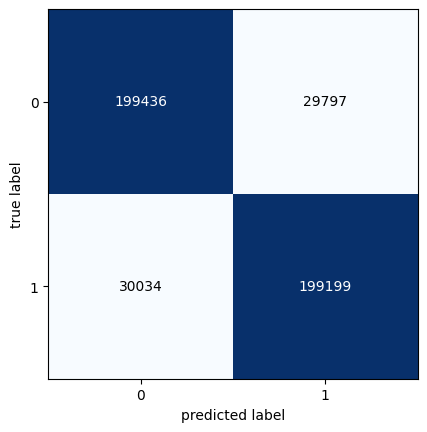

Threshold: 0.45
Accuracy: 0.8694974109312359
Recall: 0.8689804696531477
Precision: 0.8698798232283533
Beta_f2_score: 0.869160191565264
==========================Val metrics================================


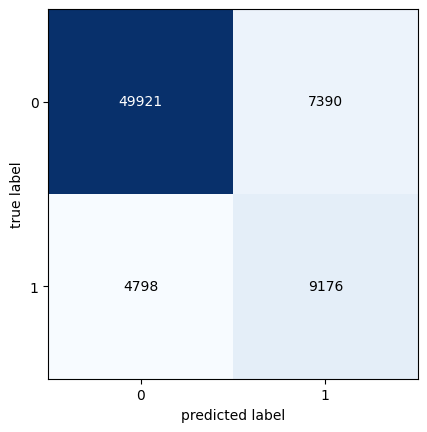

Threshold: 0.45
Accuracy: 0.8290243389212317
Recall: 0.6566480606841276
Precision: 0.5539055897621634
Beta_f2_score: 0.6331594490905578
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.725 + 3.286*pincode_11650 + 3.218*pincode_86630 + 0.287*term + 0.182*dti + 0.162*open_acc + 0.14*revol_util + 0.093*installment + 0.068*state + 0.019*emp_length + 0.006*grade_E + 0.004*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.029*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.219*broad_purpose_Business - 0.256*annual_inc - 0.274*initial_list_status_f - 0.344*grade_C - 0.37*verification_status_Source Verified - 0.386*broad_purpose_Home - 0.526*application_type_DIRECT_PAY - 0.599*verification_status_Not Verified - 0.608*issue_d_Q_2 - 0.635*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.666*issue_d_Q_3 - 0.671*earliest_cr_line_Q_2 - 0.681*earliest_cr_line_Q_3 - 0.686*earliest_cr_line_Q_1 - 0.721*broad_purpose_Energy - 

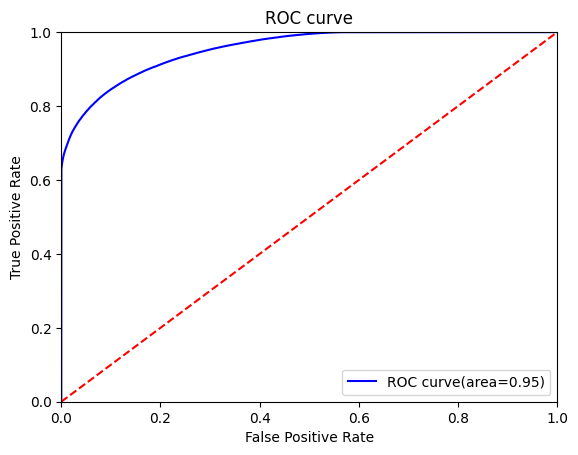

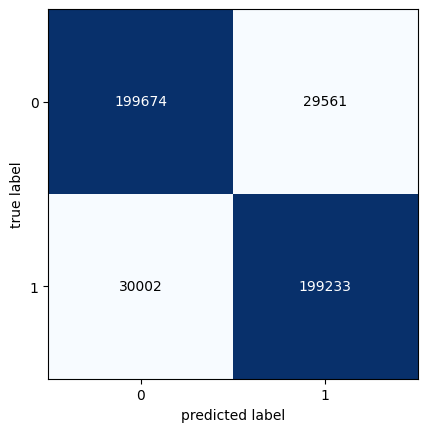

Threshold: 0.45
Accuracy: 0.8700831024930747
Recall: 0.8691212074944925
Precision: 0.8707964369695009
Beta_f2_score: 0.8694557375446657
==========================Val metrics================================


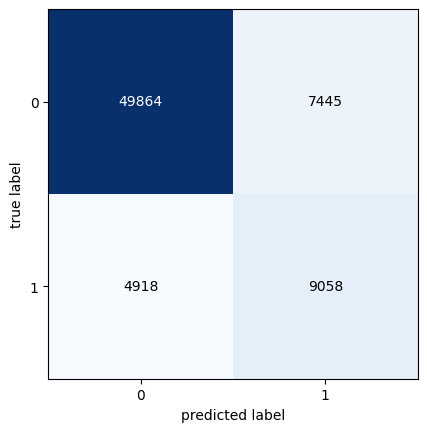

Threshold: 0.45
Accuracy: 0.8265694045030512
Recall: 0.6481110475100171
Precision: 0.5488699024419802
Beta_f2_score: 0.6254920104409795
==========================End of Folds================================
time taken(mins):  5.61476598183314
param_dict[best_estimator]:  LogisticRegression(solver='liblinear')
param_dict[best_val_accuracy]:  0.8280236884026241
param_dict[best_val_f_betascore]:  0.6304982149524127
param_dict[best_val_recall]:  0.6537927730908795
param_dict[best_val_precision]:  0.5518531913566405
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.474 + 2.603*pincode_11650 + 2.561*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.137*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.025*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.134*broad_purpose_Business - 0.156*revol_bal - 0.192*total_acc - 0.25*annual_inc - 0.261*in

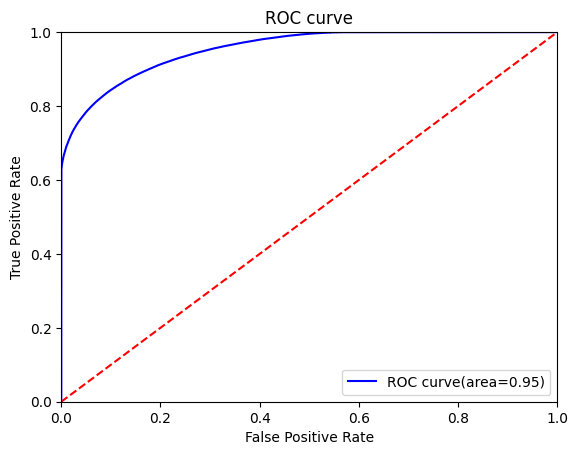

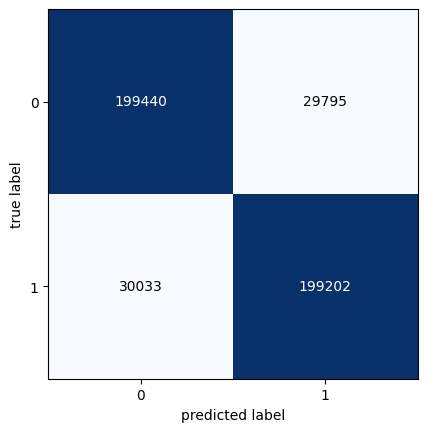

Threshold: 0.45
Accuracy: 0.8695050930268066
Recall: 0.8689859750910638
Precision: 0.8698891251850461
Beta_f2_score: 0.8691664550494486
==========================Val metrics================================


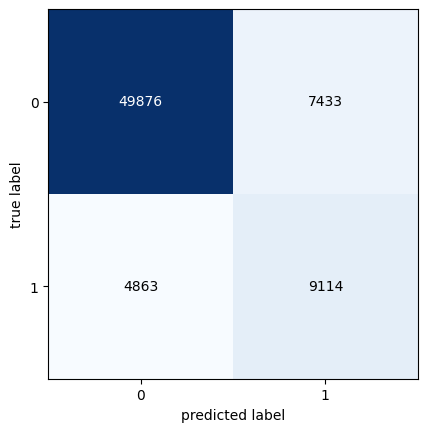

Threshold: 0.45
Accuracy: 0.8275117133799063
Recall: 0.652071259927023
Precision: 0.550794705989001
Beta_f2_score: 0.6289421019943413
============Fold 2=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.927 + 3.37*pincode_11650 + 3.294*pincode_86630 + 0.296*term + 0.187*dti + 0.167*open_acc + 0.141*revol_util + 0.105*installment + 0.043*state + 0.028*emp_length + 0.001*grade_E - 0.009*pub_rec - 0.022*mort_acc - 0.039*pub_rec_bankruptcies - 0.055*grade_F - 0.09*grade_D - 0.148*revol_bal - 0.181*total_acc - 0.222*broad_purpose_Business - 0.25*annual_inc - 0.261*initial_list_status_f - 0.342*grade_C - 0.355*broad_purpose_Education - 0.386*verification_status_Source Verified - 0.39*broad_purpose_Home - 0.479*broad_purpose_Energy - 0.576*issue_d_Q_2 - 0.593*application_type_DIRECT_PAY - 0.601*verification_status_Not Verified - 0.63*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.639*issue_d_Q_3 - 0.664*earliest_cr_line_Q_3 - 0.676*earliest_cr_line_Q_2 - 0.

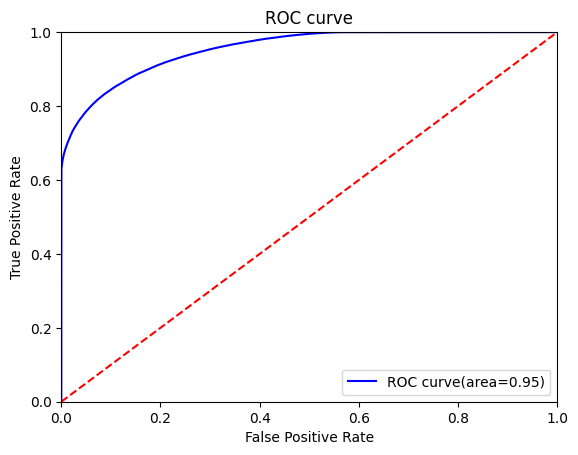

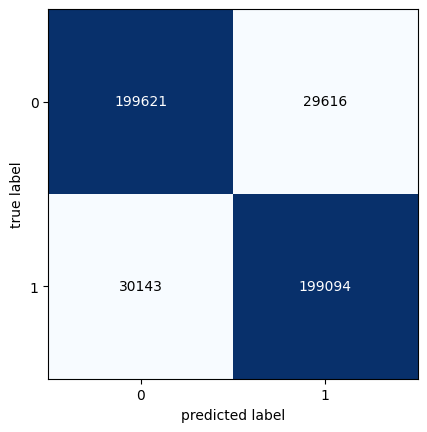

Threshold: 0.45
Accuracy: 0.8696567308069815
Recall: 0.8685072654065443
Precision: 0.870508504219317
Beta_f2_score: 0.868906776716961
==========================Val metrics================================


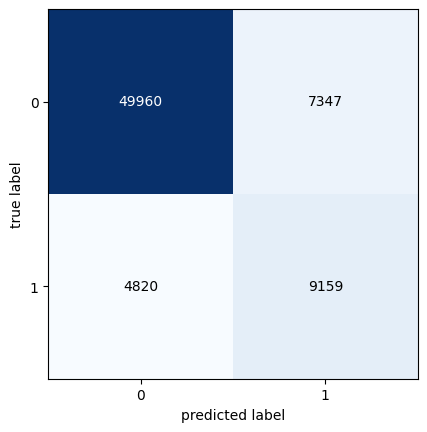

Threshold: 0.45
Accuracy: 0.8293213253654294
Recall: 0.6551970813362902
Precision: 0.554889131225009
Beta_f2_score: 0.6323354781696171
============Fold 3=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.929 + 3.349*pincode_11650 + 3.326*pincode_86630 + 0.295*term + 0.19*dti + 0.18*open_acc + 0.145*revol_util + 0.101*installment + 0.042*state + 0.038*emp_length - 0.015*mort_acc - 0.028*pub_rec - 0.029*pub_rec_bankruptcies - 0.033*grade_F - 0.104*grade_D - 0.15*revol_bal - 0.197*total_acc - 0.198*broad_purpose_Business - 0.242*annual_inc - 0.253*initial_list_status_f - 0.348*grade_C - 0.373*verification_status_Source Verified - 0.412*broad_purpose_Home - 0.544*broad_purpose_Education - 0.576*application_type_DIRECT_PAY - 0.576*broad_purpose_Energy - 0.588*verification_status_Not Verified - 0.608*issue_d_Q_2 - 0.639*home_ownership_MORTGAGE - 0.66*issue_d_Q_1 - 0.669*earliest_cr_line_Q_3 - 0.673*issue_d_Q_3 - 0.678*earliest_cr_line_Q_2 - 0.681*earliest_c

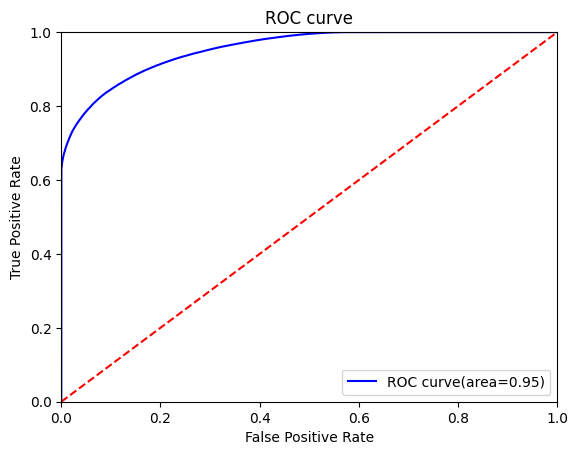

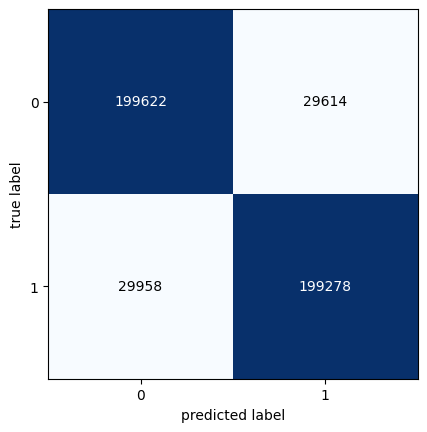

Threshold: 0.45
Accuracy: 0.8700640388071682
Recall: 0.869313720358059
Precision: 0.8706202051622599
Beta_f2_score: 0.8695747035352355
==========================Val metrics================================


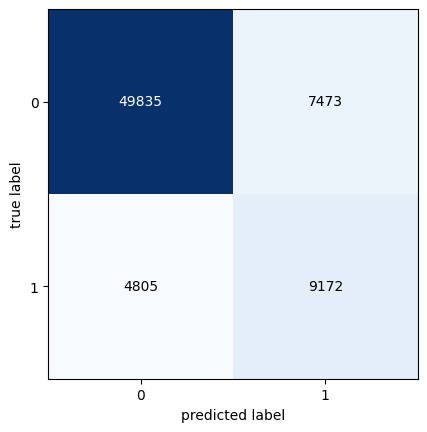

Threshold: 0.45
Accuracy: 0.8277618012204531
Recall: 0.6562209343922157
Precision: 0.5510363472514268
Beta_f2_score: 0.6320896448113792
============Fold 4=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.964 + 3.348*pincode_11650 + 3.297*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.138*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.026*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.133*broad_purpose_Business - 0.157*revol_bal - 0.193*total_acc - 0.251*annual_inc - 0.262*initial_list_status_f - 0.337*broad_purpose_Energy - 0.34*grade_C - 0.388*verification_status_Source Verified - 0.4*broad_purpose_Education - 0.413*broad_purpose_Home - 0.58*issue_d_Q_2 - 0.605*verification_status_Not Verified - 0.625*application_type_DIRECT_PAY - 0.639*home_ownership_MORTGAGE - 0.64*issue_d_Q_1 - 0.657*issue_d_Q_3 - 0.671*earliest_cr_line_Q_3 - 0.682*earliest_cr_line_Q_2 - 0.6

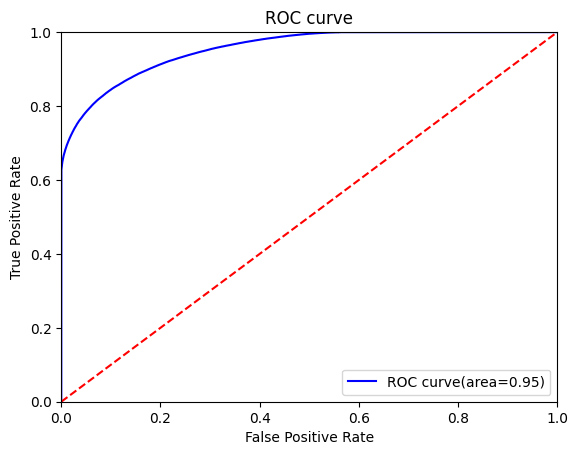

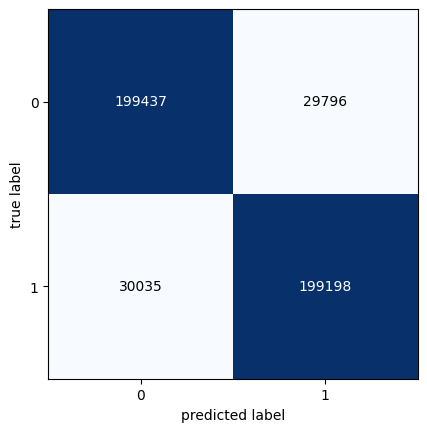

Threshold: 0.45
Accuracy: 0.8694974109312359
Recall: 0.8689761072794929
Precision: 0.8698830537044638
Beta_f2_score: 0.8691573452386977
==========================Val metrics================================


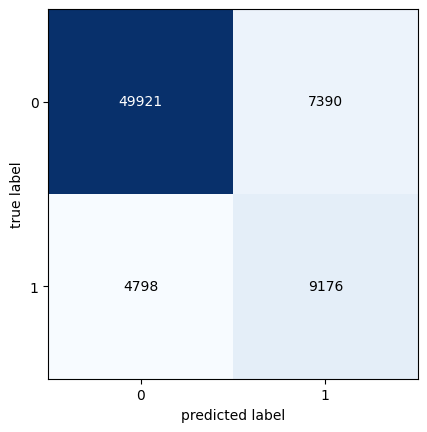

Threshold: 0.45
Accuracy: 0.8290243389212317
Recall: 0.6566480606841276
Precision: 0.5539055897621634
Beta_f2_score: 0.6331594490905578
============Fold 5=============
EQUATION: 
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=12.96 + 3.362*pincode_11650 + 3.292*pincode_86630 + 0.287*term + 0.182*dti + 0.162*open_acc + 0.14*revol_util + 0.093*installment + 0.068*state + 0.019*emp_length + 0.006*grade_E + 0.004*grade_F - 0.003*mort_acc - 0.025*pub_rec_bankruptcies - 0.029*pub_rec - 0.097*grade_D - 0.135*revol_bal - 0.182*total_acc - 0.219*broad_purpose_Business - 0.256*annual_inc - 0.274*initial_list_status_f - 0.344*grade_C - 0.37*verification_status_Source Verified - 0.386*broad_purpose_Home - 0.527*application_type_DIRECT_PAY - 0.599*verification_status_Not Verified - 0.608*issue_d_Q_2 - 0.635*issue_d_Q_1 - 0.636*home_ownership_MORTGAGE - 0.666*issue_d_Q_3 - 0.671*earliest_cr_line_Q_2 - 0.681*earliest_cr_line_Q_3 - 0.686*earliest_cr_line_Q_1 - 0.721*broad_purpose_Energy - 0

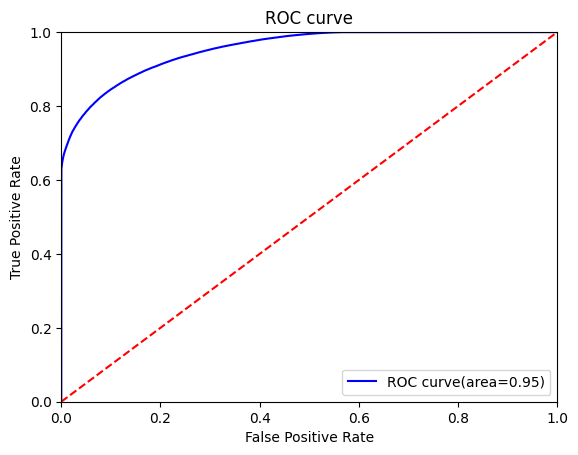

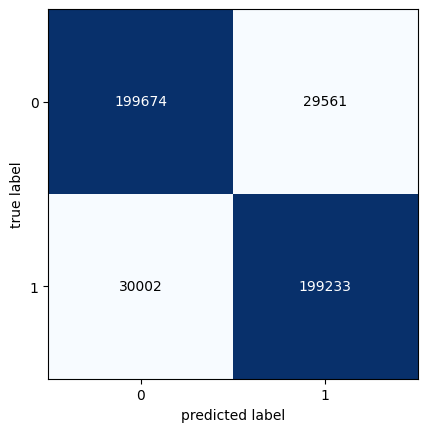

Threshold: 0.45
Accuracy: 0.8700831024930747
Recall: 0.8691212074944925
Precision: 0.8707964369695009
Beta_f2_score: 0.8694557375446657
==========================Val metrics================================


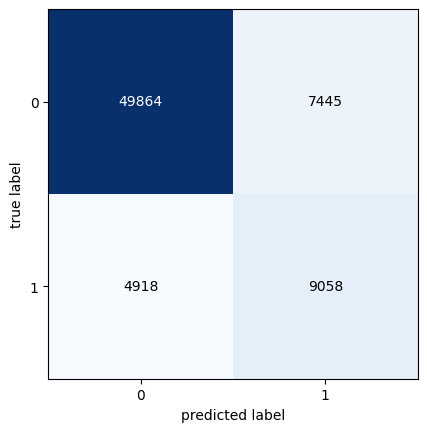

Threshold: 0.45
Accuracy: 0.8265694045030512
Recall: 0.6481110475100171
Precision: 0.5488699024419802
Beta_f2_score: 0.6254920104409795
==========================End of Folds================================
time taken(mins):  5.151092143853505
param_dict[best_estimator]:  LogisticRegression(solver='liblinear')
param_dict[best_val_accuracy]:  0.8280236884026241
param_dict[best_val_f_betascore]:  0.6304982149524127
param_dict[best_val_recall]:  0.6537927730908795
param_dict[best_val_precision]:  0.5518531913566405
param_dict[best_val_th]:  0.45
param_dict[best_equation]:  log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.474 + 2.603*pincode_11650 + 2.561*pincode_86630 + 0.293*term + 0.19*dti + 0.175*open_acc + 0.137*revol_util + 0.1*installment + 0.039*state + 0.028*emp_length - 0.013*grade_E - 0.017*mort_acc - 0.023*pub_rec_bankruptcies - 0.025*pub_rec - 0.054*grade_F - 0.097*grade_D - 0.134*broad_purpose_Business - 0.156*revol_bal - 0.192*total_acc - 0.25*annual_inc - 0.261*i

In [30]:
param=[
        {"classifier":[LogisticRegression(solver='liblinear')],
        "classifier__penalty":['l1','l2'],
         "classifier__C":np.logspace(0,4,3)
        }
        
    ]

estimator_pkl='best_estimator1.pkl'

find_best_logistic_regression(estimator_pkl,xtrain,ytrain,xtest,ytest,5,True,True,'log(P[loan_status:Charged off]/P[loan_status:Fully Paid])')

In [ ]:
#Dropped multicolliner Columns:  ['loan_amnt', 'int_rate', 'grade_B', 'application_type_INDIVIDUAL', 'broad_purpose_Debt']

In [ ]:
## Best Equation ##
log(P[loan_status:Charged off]/P[loan_status:Fully Paid])=9.474 
+ 2.603*pincode_11650 
+ 2.561*pincode_86630 
+ 0.293*term 
+ 0.19*dti 
+ 0.175*open_acc 
+ 0.137*revol_util 
+ 0.1*installment 
+ 0.039*state 
+ 0.028*emp_length 
- 0.013*grade_E 
- 0.017*mort_acc 
- 0.023*pub_rec_bankruptcies 
- 0.025*pub_rec 
- 0.054*grade_F 
- 0.097*grade_D 
- 0.134*broad_purpose_Business 
- 0.156*revol_bal 
- 0.192*total_acc 
- 0.25*annual_inc 
- 0.261*initial_list_status_f 
- 0.319*broad_purpose_Energy 
- 0.34*grade_C 
- 0.384*broad_purpose_Education 
- 0.387*verification_status_Source Verified 
- 0.413*broad_purpose_Home 
- 0.578*issue_d_Q_2 
- 0.59*application_type_DIRECT_PAY 
- 0.603*verification_status_Not Verified 
- 0.637*home_ownership_MORTGAGE 
- 0.638*issue_d_Q_1 
- 0.655*issue_d_Q_3 
- 0.669*earliest_cr_line_Q_3 
- 0.68*earliest_cr_line_Q_2 
- 0.692*earliest_cr_line_Q_1 
- 0.798*home_ownership_OWN 
- 0.969*home_ownership_OTHER 
- 0.989*sub_grade_4 
- 1.021*sub_grade_3 
- 1.033*sub_grade_2 
- 1.072*sub_grade_1 
- 1.648*grade_A 
- 7.354*pincode_48052 
- 7.359*pincode_70466 
- 7.382*pincode_30723 
- 7.388*pincode_22690 
- 14.575*pincode_05113 
- 14.576*pincode_29597 
- 14.583*pincode_00813